# NFT prediction project

#New Dataset

In [1]:
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import linear_model, metrics
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt # plotting

In [2]:
!wget https://raw.githubusercontent.com/aaronnke/ml_data/master/combined_dataset.csv

--2022-08-22 15:52:57--  https://raw.githubusercontent.com/aaronnke/ml_data/master/combined_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 142125 (139K) [text/plain]
Saving to: ‘combined_dataset.csv’

combined_dataset.cs 100%[===================>] 138.79K  --.-KB/s    in 0.01s   

2022-08-22 15:52:57 (9.32 MB/s) - ‘combined_dataset.csv’ saved [142125/142125]



In [3]:
df = pd.read_csv('combined_dataset.csv', index_col=0)

In [4]:
list(df.columns)

['t_tweets_today',
 't_retweets_today',
 't_replies_today',
 't_likes_today',
 't_quotes_today',
 't_unique_tweeters_today',
 't_unique_verified_tweeters_today',
 't_followers_today',
 't_sent_str_pos_today',
 't_sent_weak_pos_today',
 't_sent_neutral_today',
 't_sent_weak_neg_today',
 't_sent_str_neg_today',
 't_tweets_ytd',
 't_retweets_ytd',
 't_replies_ytd',
 't_likes_ytd',
 't_quotes_ytd',
 't_unique_tweeters_ytd',
 't_unique_verified_tweeters_ytd',
 't_followers_ytd',
 't_sent_str_pos_ytd',
 't_sent_weak_pos_ytd',
 't_sent_neutral_ytd',
 't_sent_weak_neg_ytd',
 't_sent_str_neg_ytd',
 't_tweets_%_change_day',
 't_retweets_%_change_day',
 't_replies_%_change_day',
 't_likes_%_change_day',
 't_quotes_%_change_day',
 't_unique_tweeters_%_change_day',
 't_unique_verified_tweeters_%_change_day',
 't_followers_%_change_day',
 't_sent_str_pos_%_change_day',
 't_sent_weak_pos_%_change_day',
 't_sent_neutral_%_change_day',
 't_sent_weak_neg_%_change_day',
 't_sent_str_neg_%_change_day',
 '

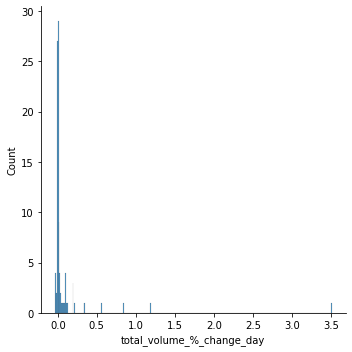

In [5]:
sns.displot(df, x="total_volume_%_change_day")

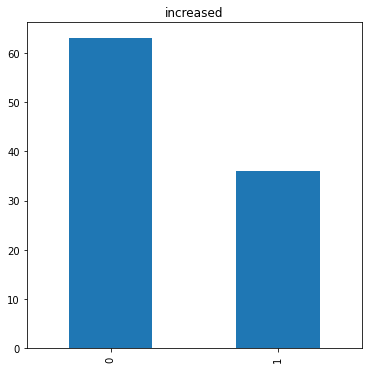

In [6]:
# see distribution of increased and not-increased collections
fig = plt.figure(figsize=(6,6)) 

df['next_day_average_price_increased'].value_counts().plot(kind='bar', 
                                     title='increased')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  after removing the cwd from sys.path.


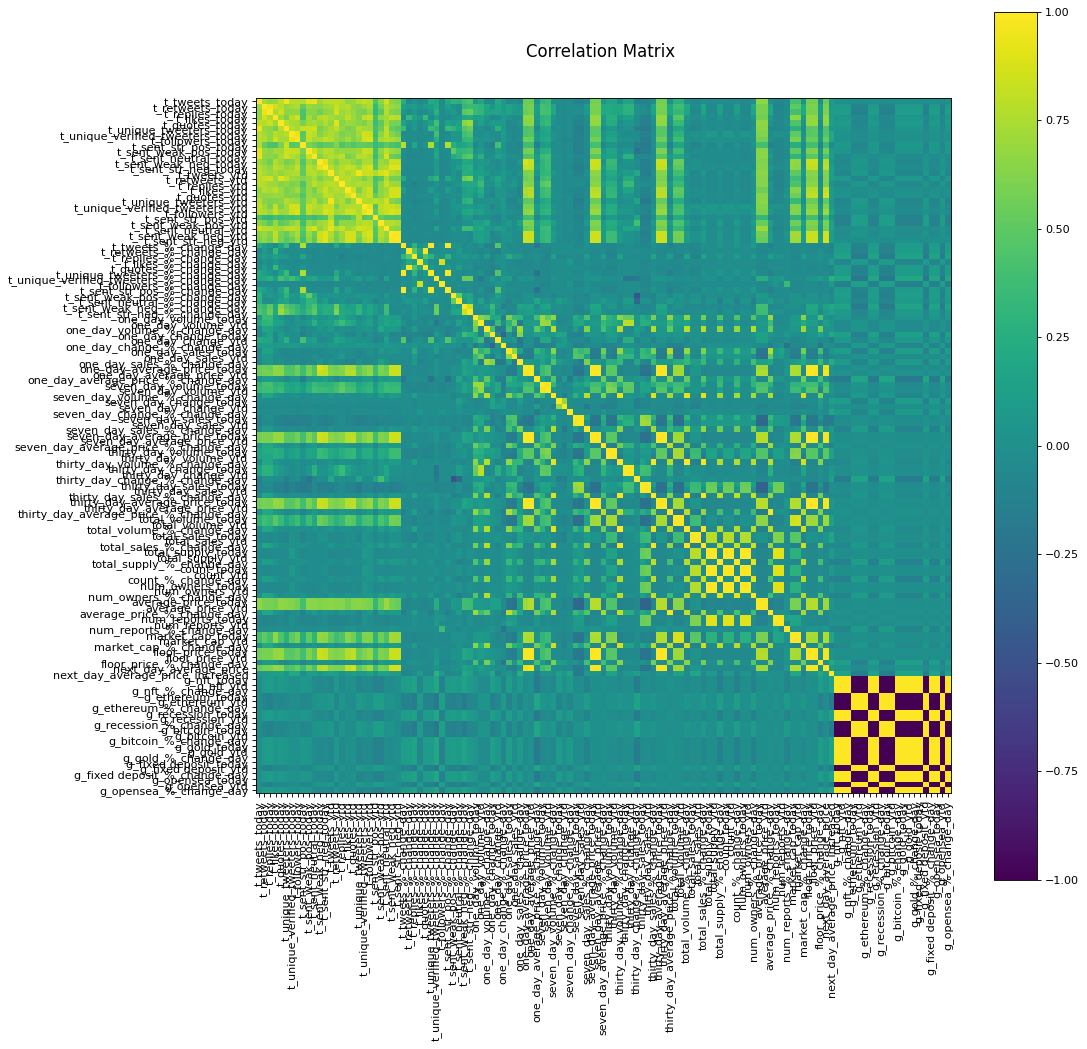

In [7]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix ', fontsize=15)
    plt.show()

plotCorrelationMatrix(df, 14)

In [8]:
corr = df.corr()
records = []
for index, row in corr.iterrows():
  for feature in corr.index:
    if row[feature] > 0.5 and not (index[:2] == "g_" and feature[:2] == "g_") and index != feature:
      record = {"x": index, "y": feature, "v": row[feature]}
      records.append(record)
corr_asc = sorted(records, key=lambda d: d['v'])
for c in corr_asc:
  print("{} {}: {}".format(c["x"], c["y"], c["v"]))

one_day_sales_ytd average_price_%_change_day: 0.5004688129925058
average_price_%_change_day one_day_sales_ytd: 0.5004688129925058
t_quotes_today t_sent_weak_pos_ytd: 0.500751407568402
t_sent_weak_pos_ytd t_quotes_today: 0.500751407568402
t_unique_verified_tweeters_today market_cap_ytd: 0.5019237377352708
market_cap_ytd t_unique_verified_tweeters_today: 0.5019237377352708
one_day_volume_%_change_day thirty_day_average_price_%_change_day: 0.5023406369998216
thirty_day_average_price_%_change_day one_day_volume_%_change_day: 0.5023406369998216
t_likes_ytd total_volume_today: 0.502879747455477
total_volume_today t_likes_ytd: 0.502879747455477
t_likes_ytd total_volume_ytd: 0.5035037817746807
total_volume_ytd t_likes_ytd: 0.5035037817746807
t_sent_weak_pos_today market_cap_ytd: 0.503597185499773
market_cap_ytd t_sent_weak_pos_today: 0.503597185499773
one_day_volume_today seven_day_volume_ytd: 0.5038837336951668
seven_day_volume_ytd one_day_volume_today: 0.5038837336951668
seven_day_volume_tod

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  """


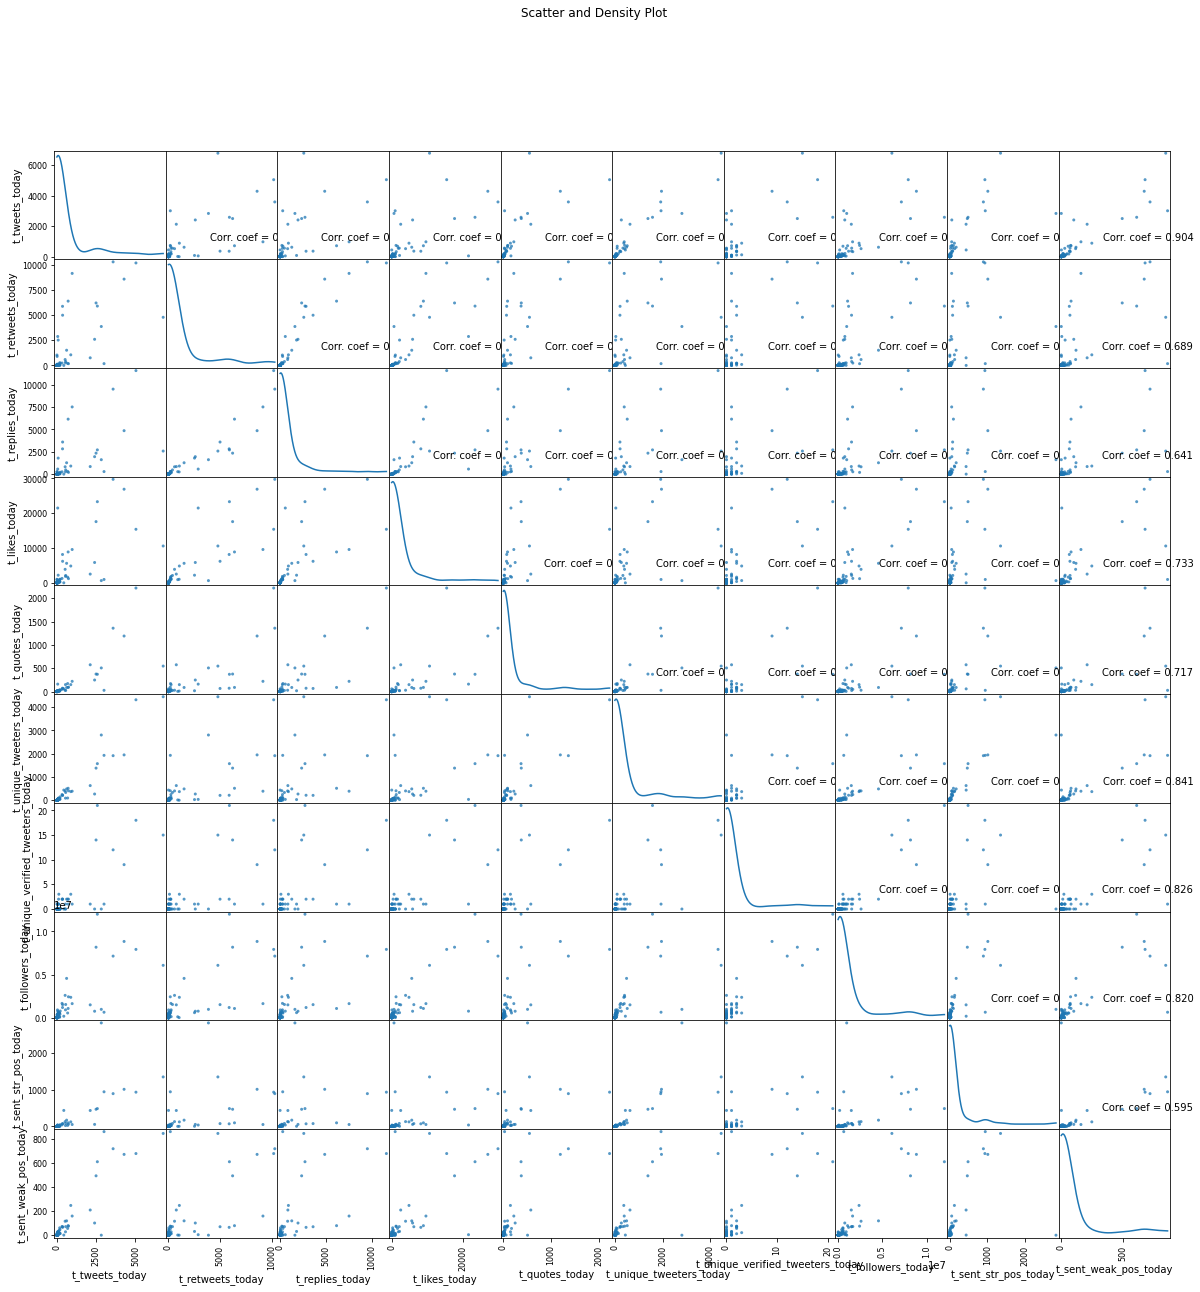

In [9]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

# scatter matrix of relationship between each two features
plotScatterMatrix(df, 20, 10)

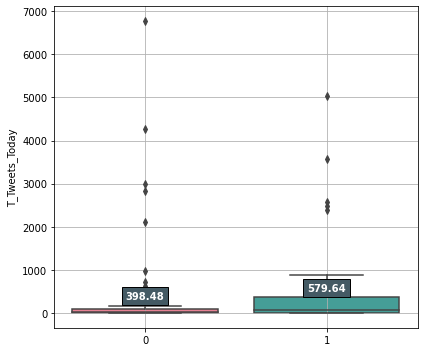

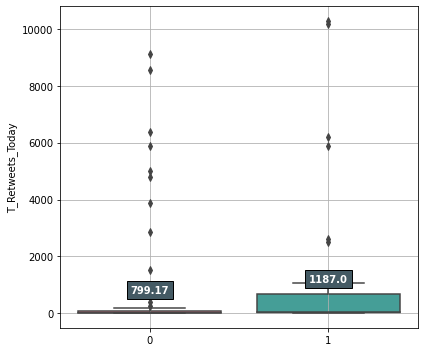

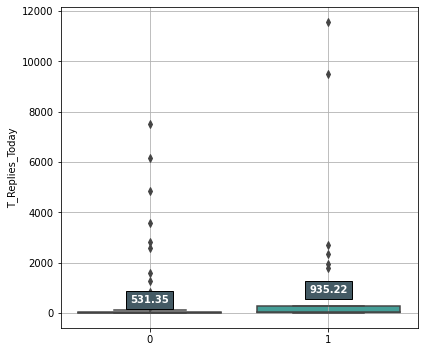

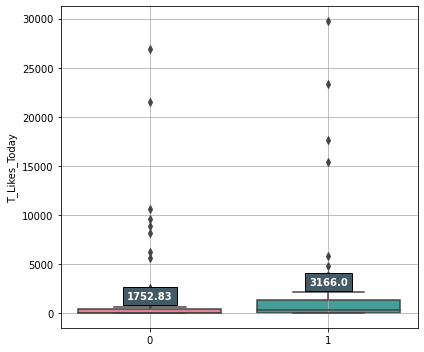

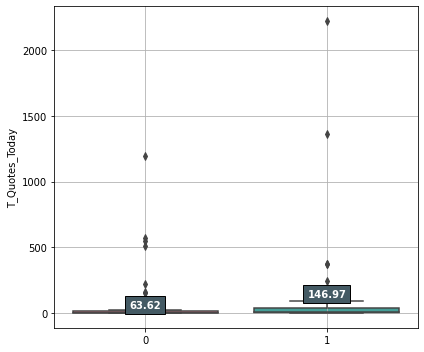

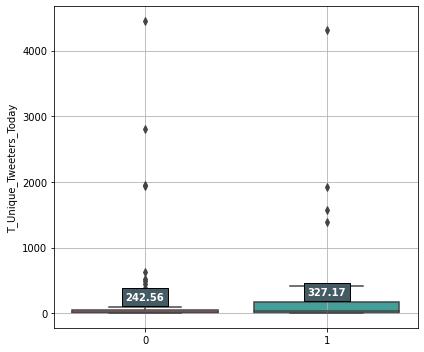

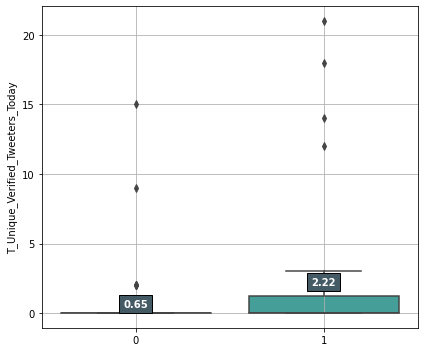

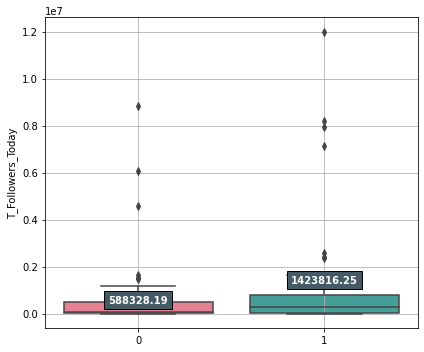

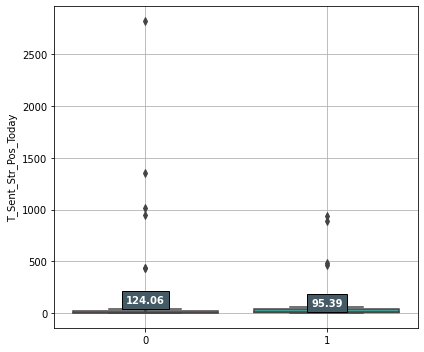

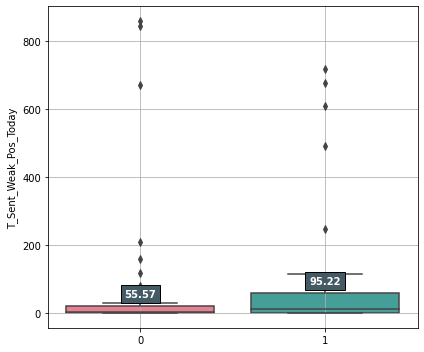

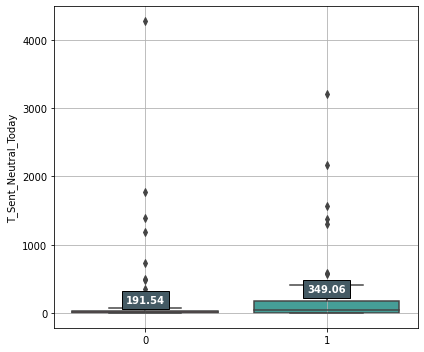

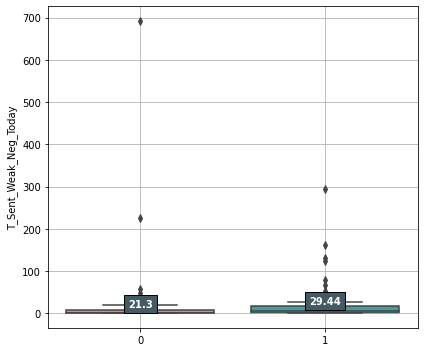

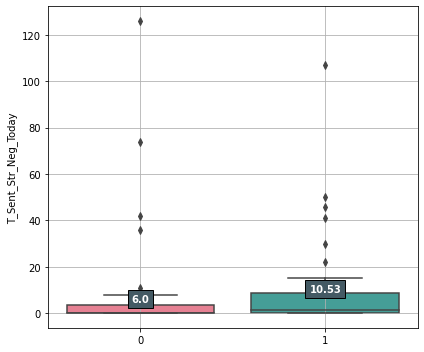

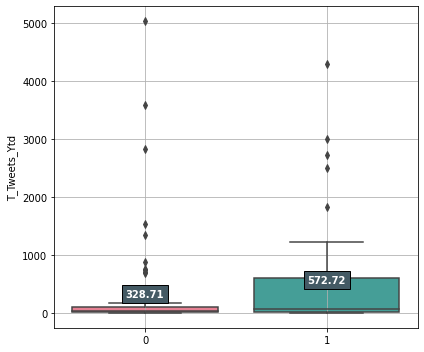

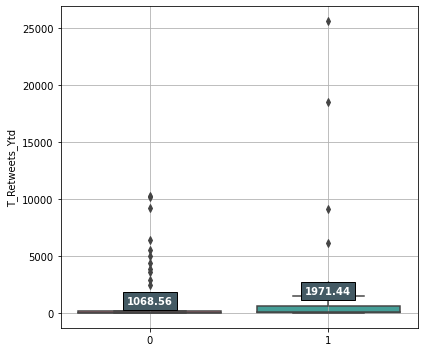

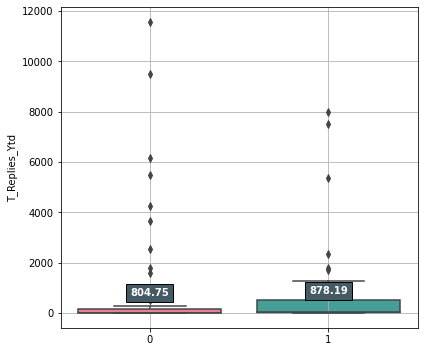

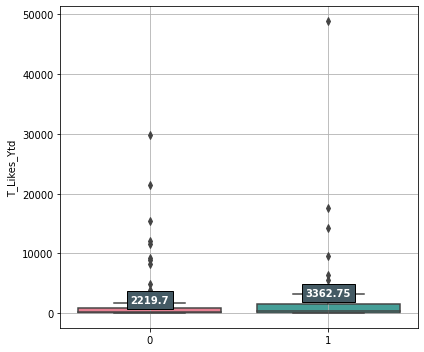

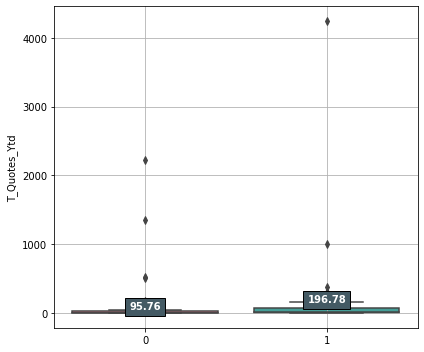

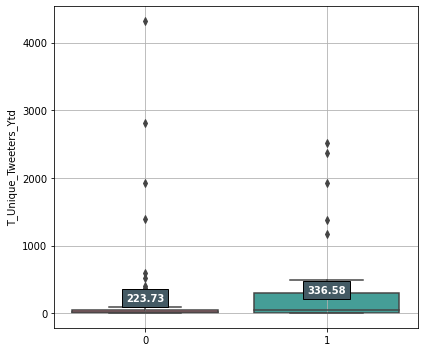

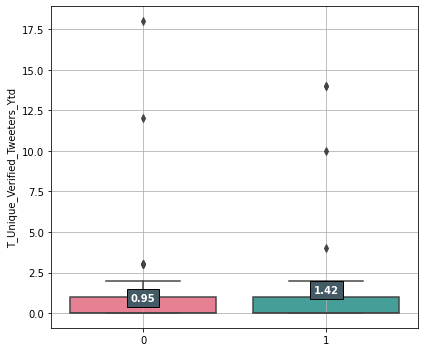

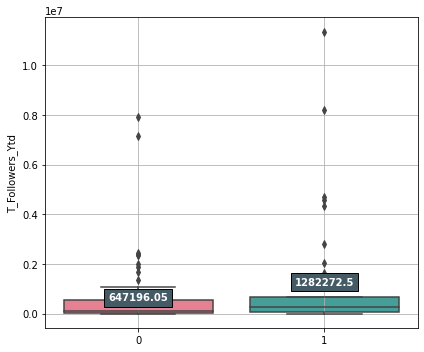

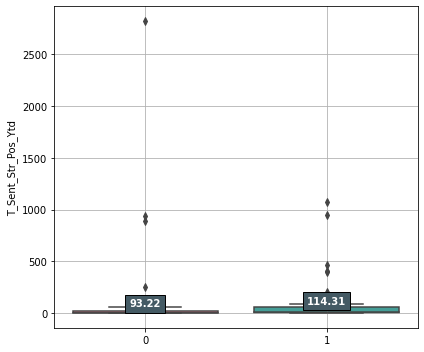

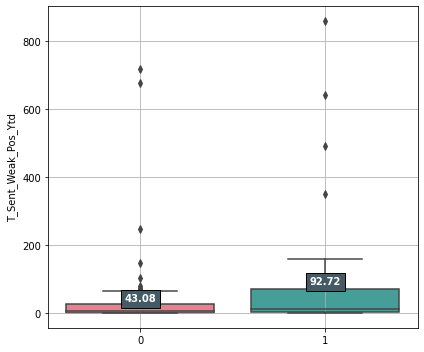

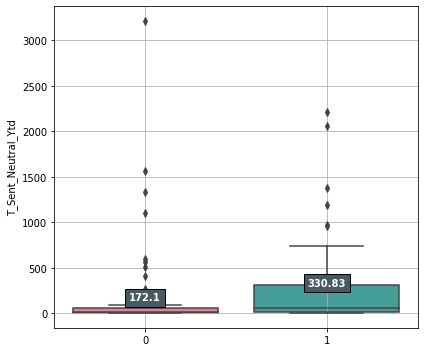

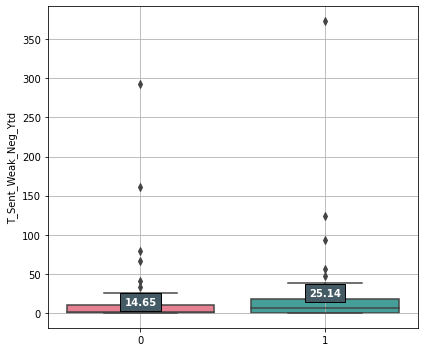

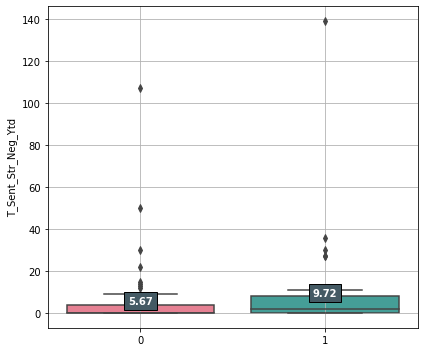

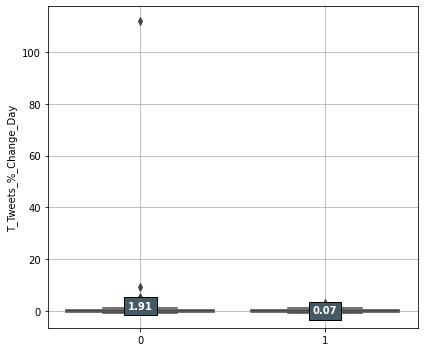

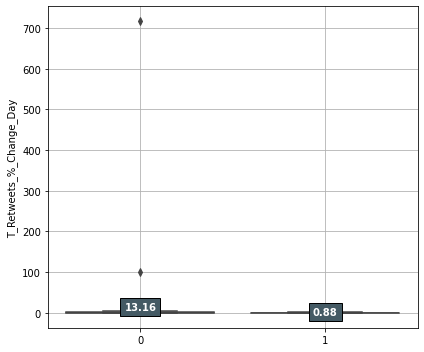

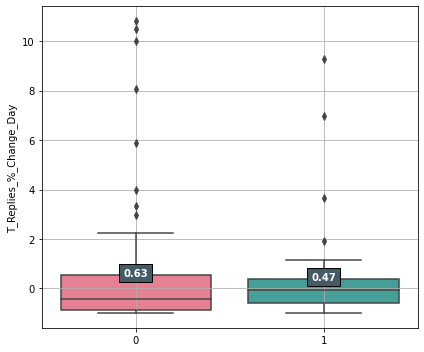

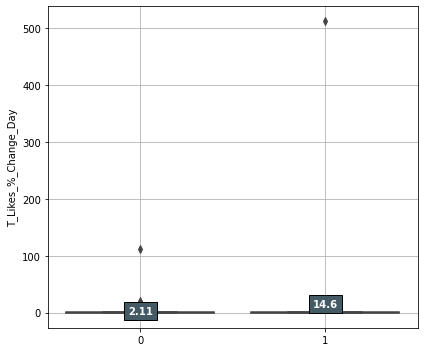

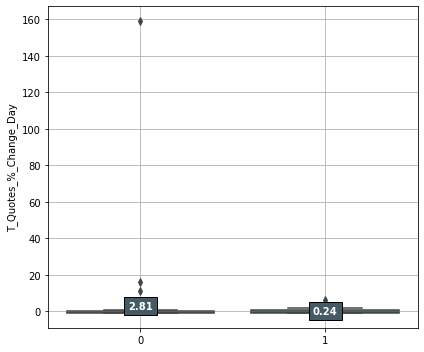

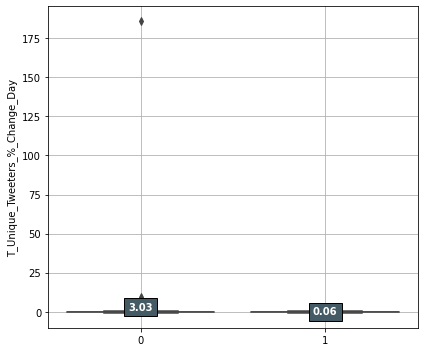

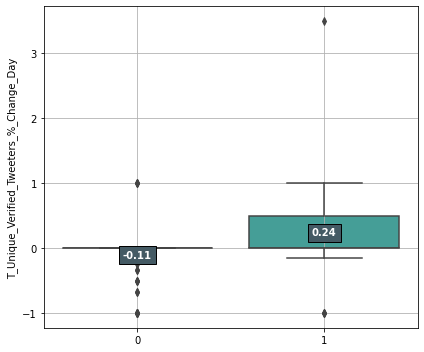

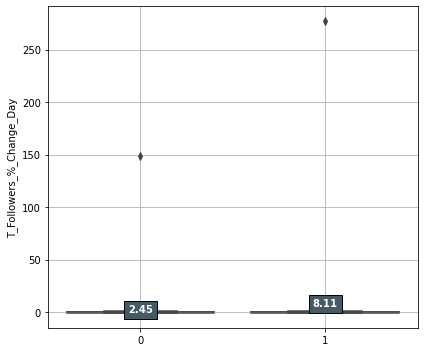

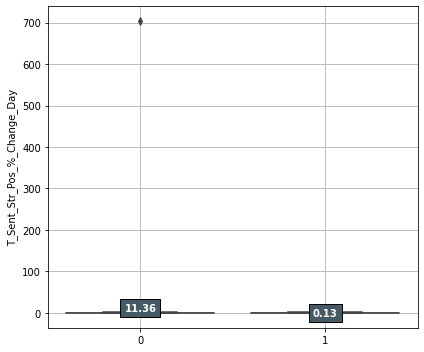

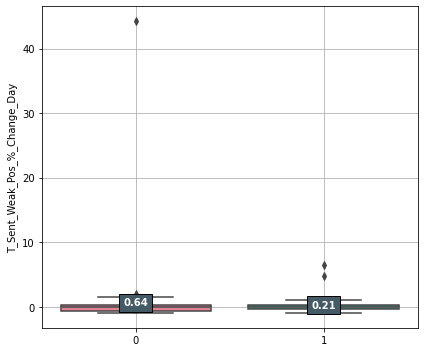

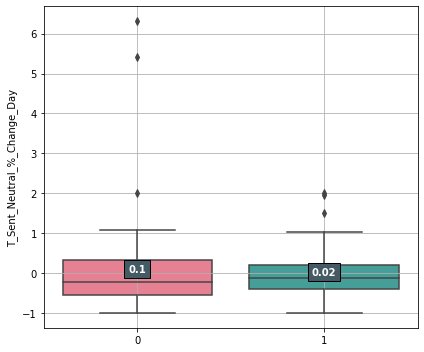

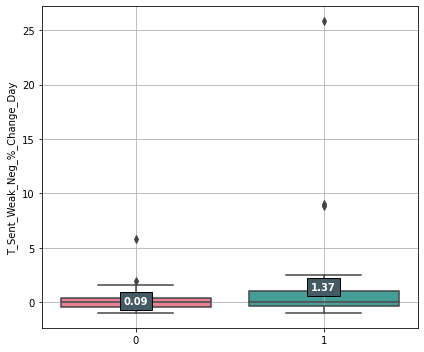

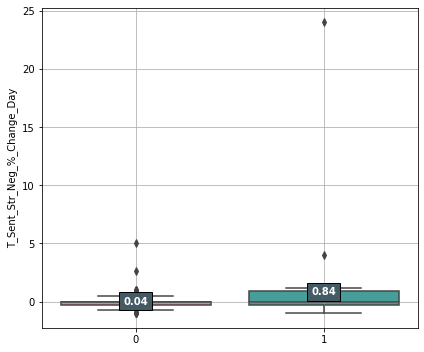

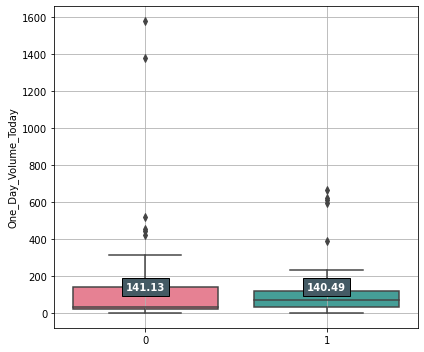

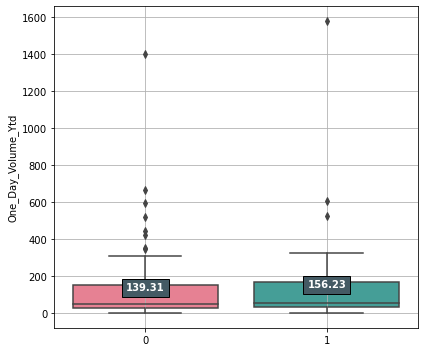

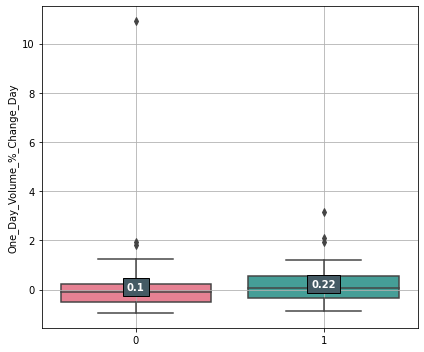

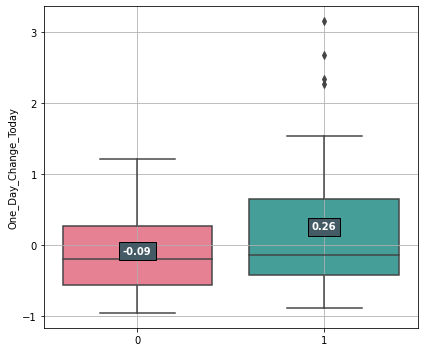

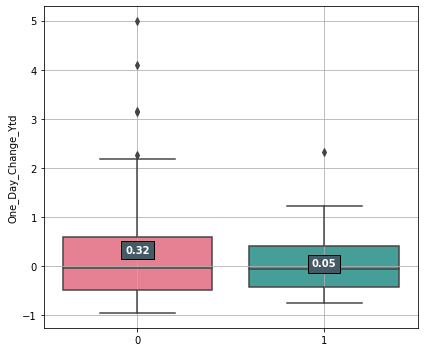

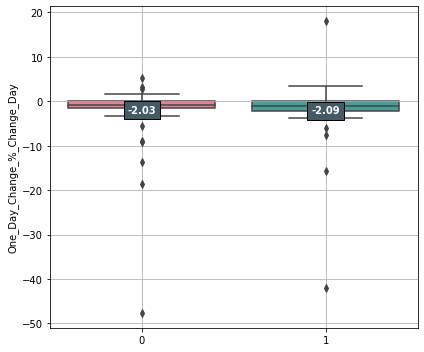

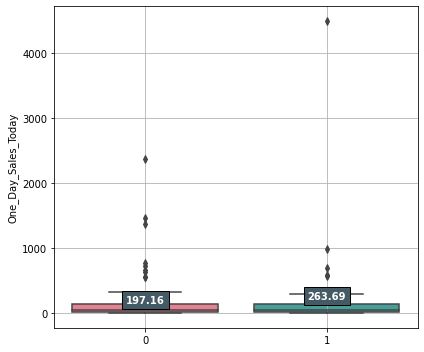

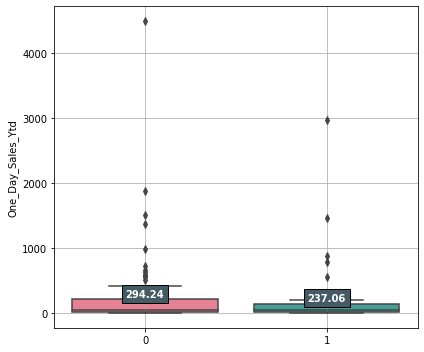

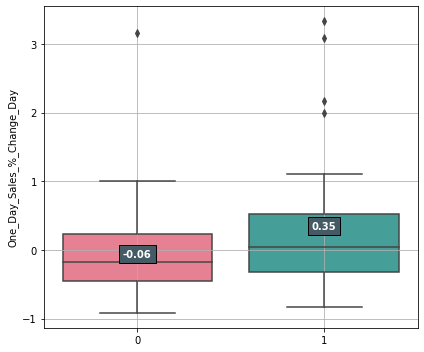

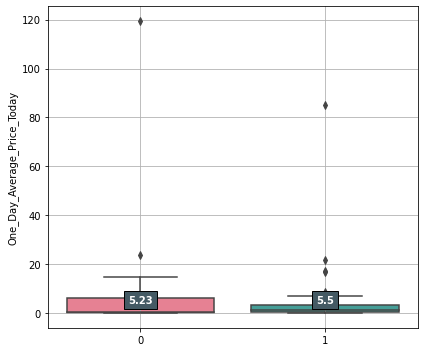

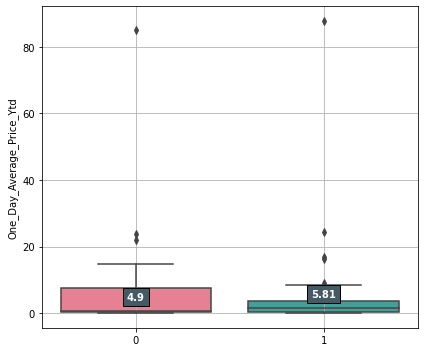

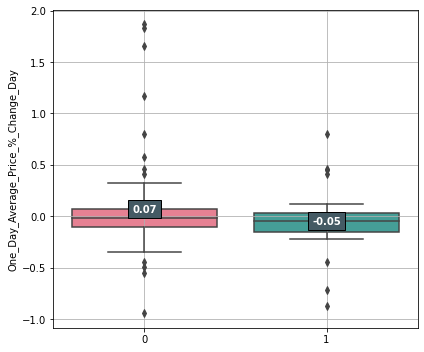

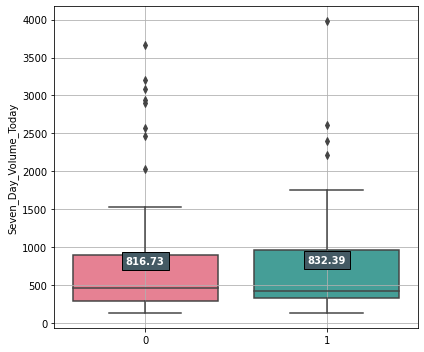

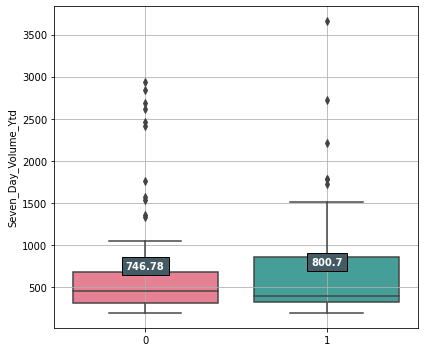

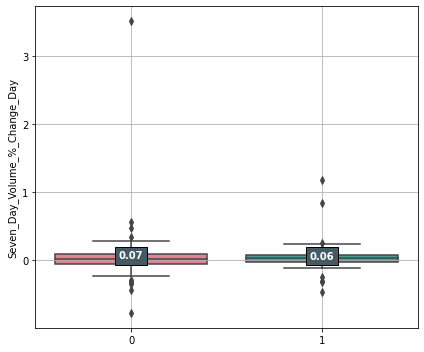

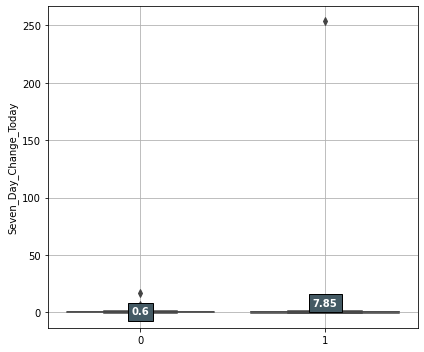

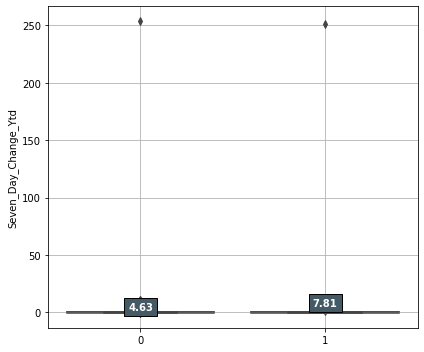

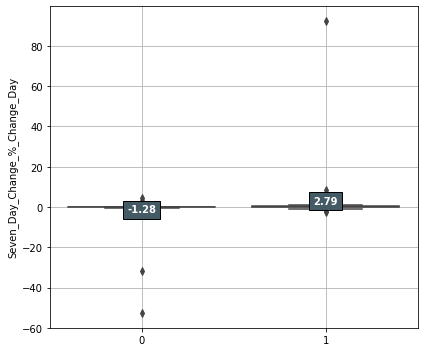

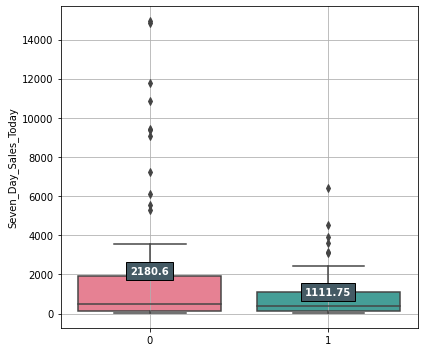

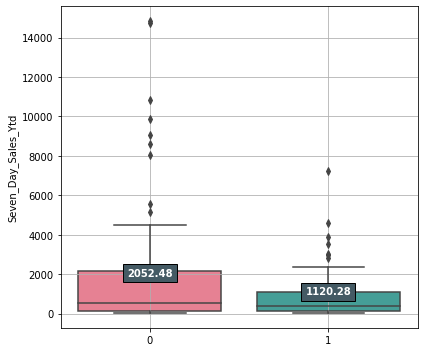

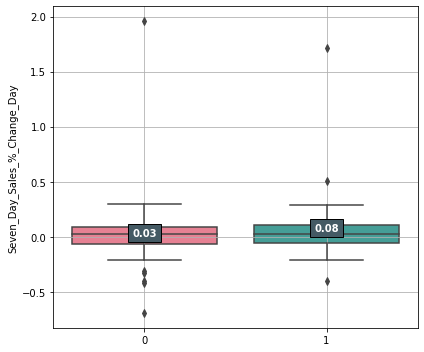

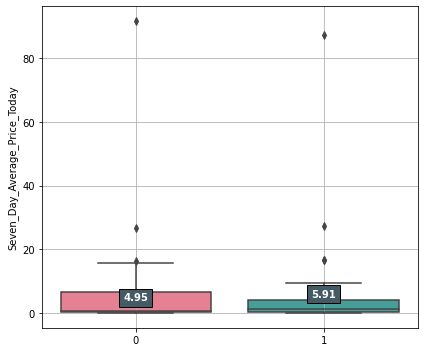

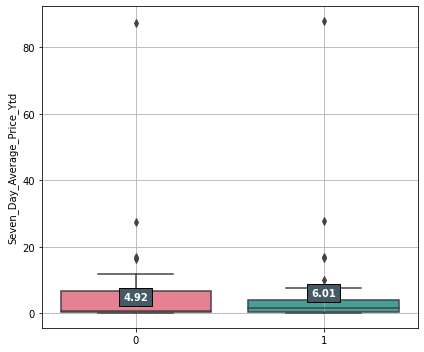

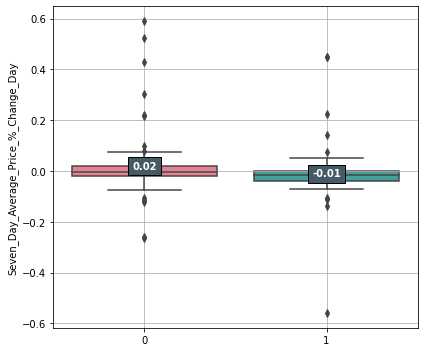

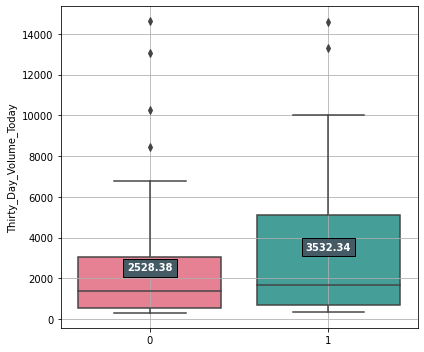

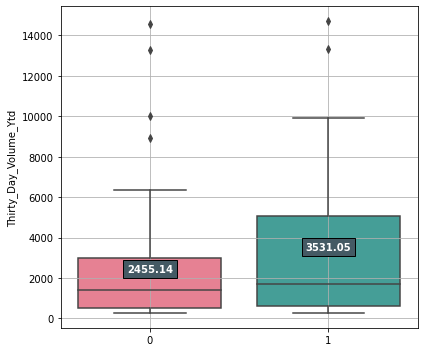

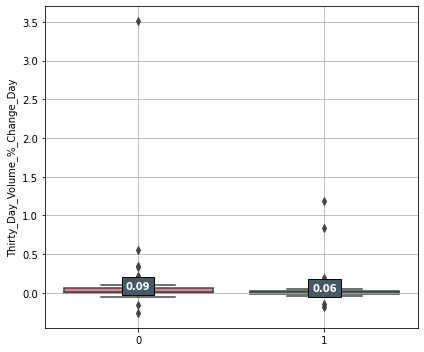

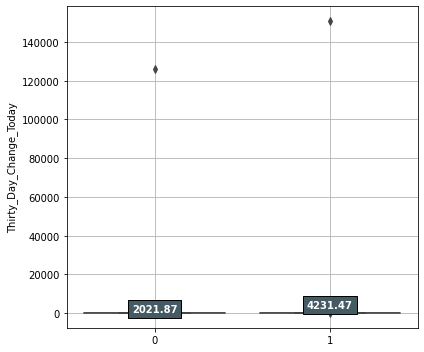

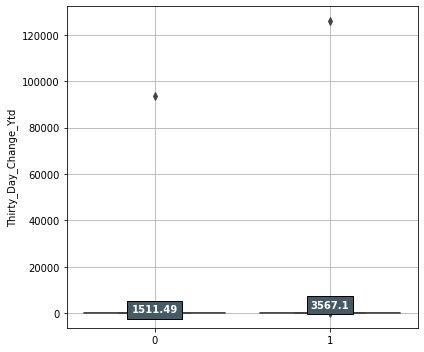

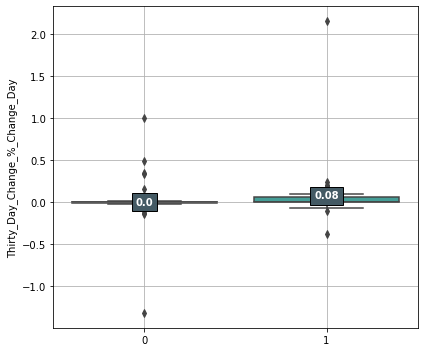

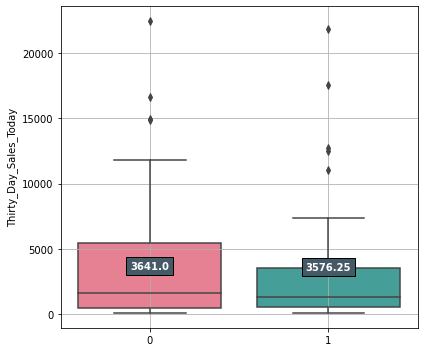

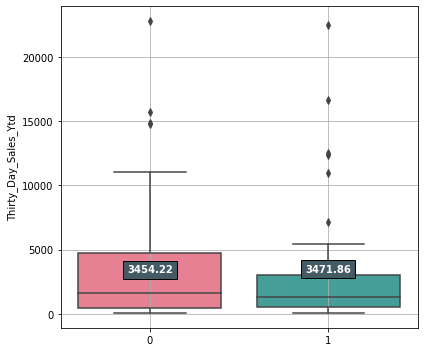

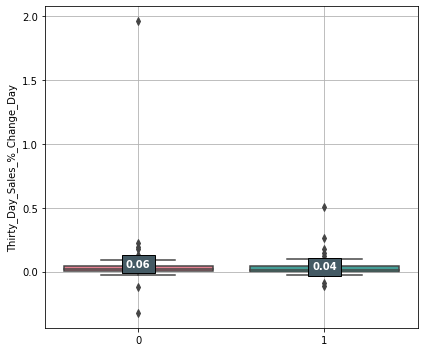

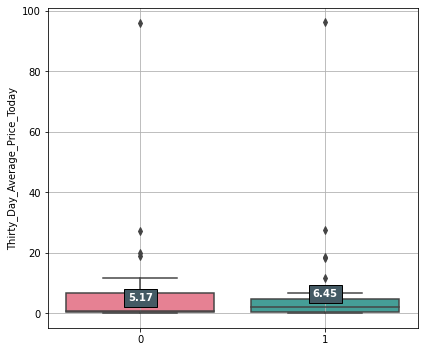

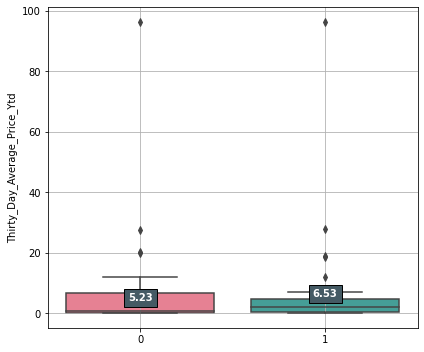

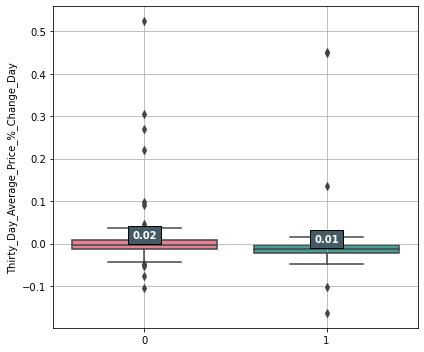

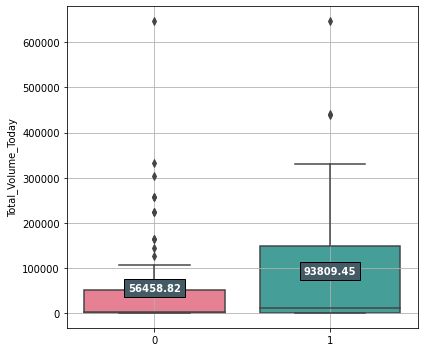

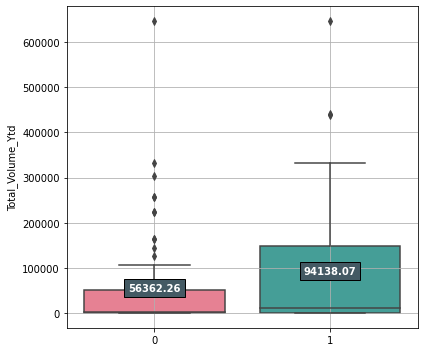

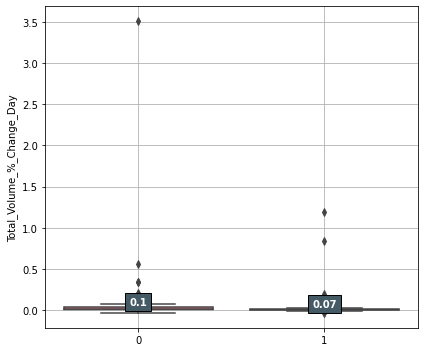

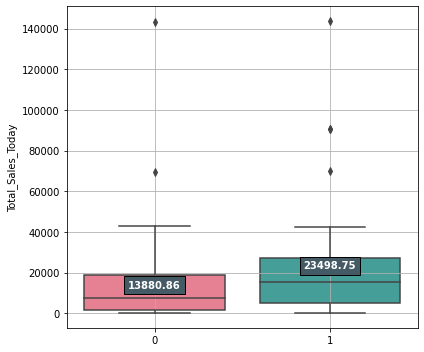

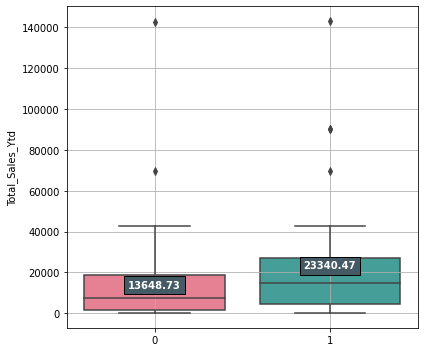

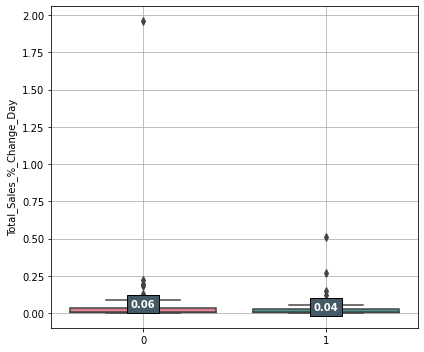

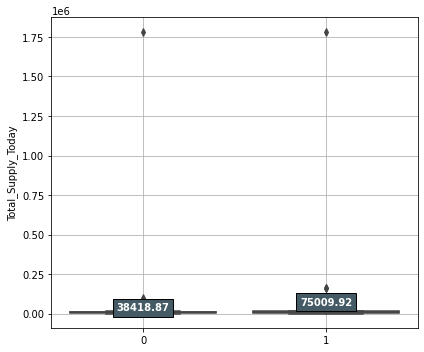

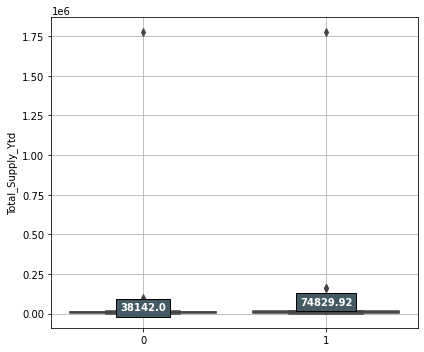

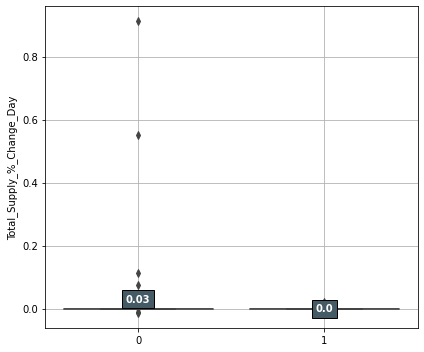

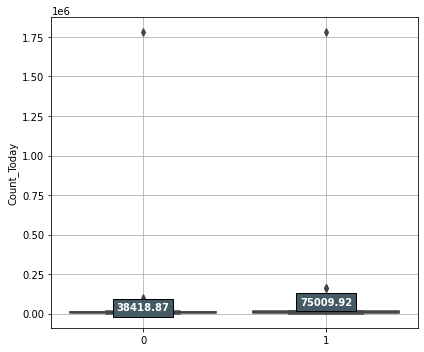

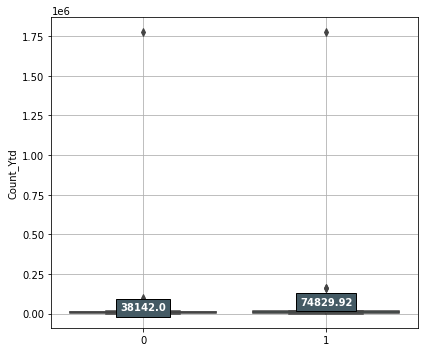

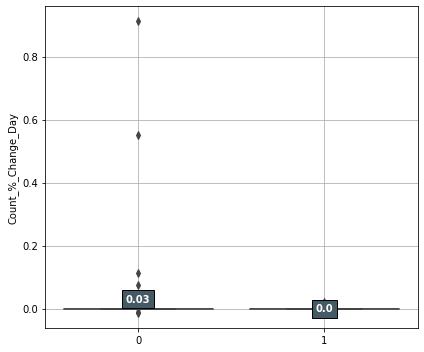

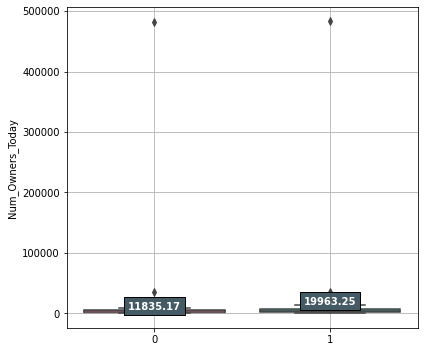

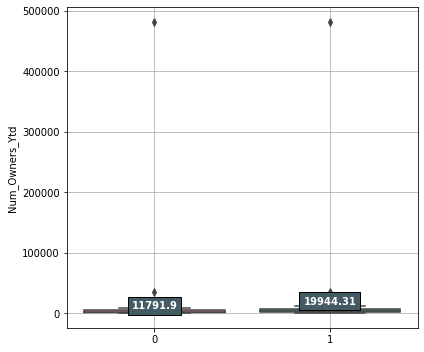

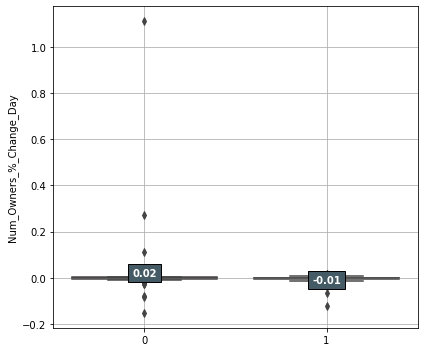

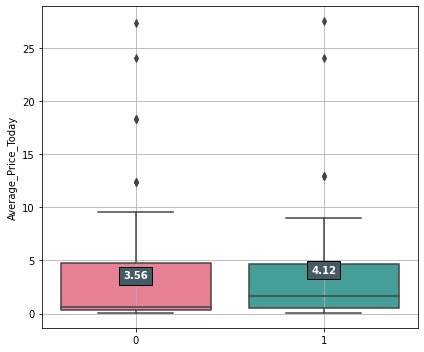

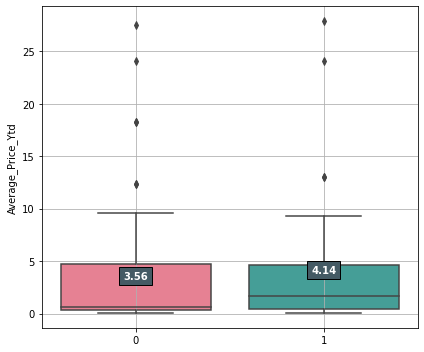

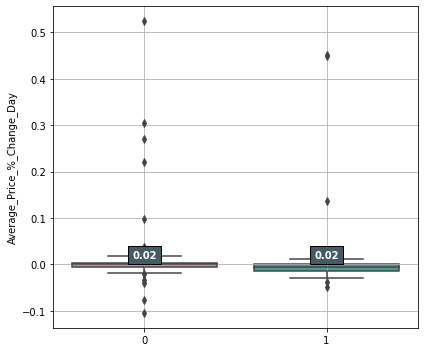

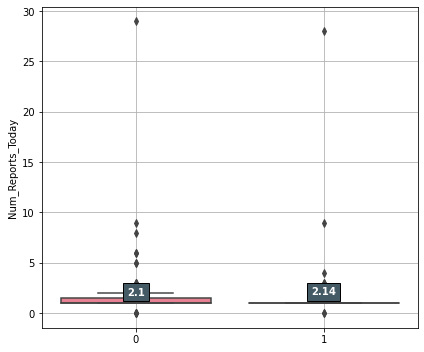

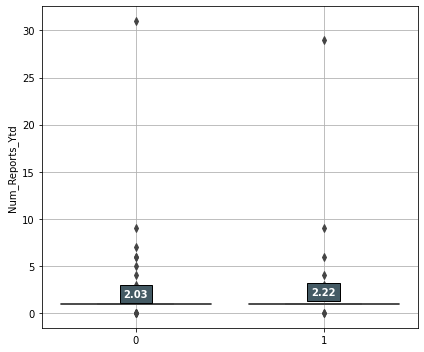

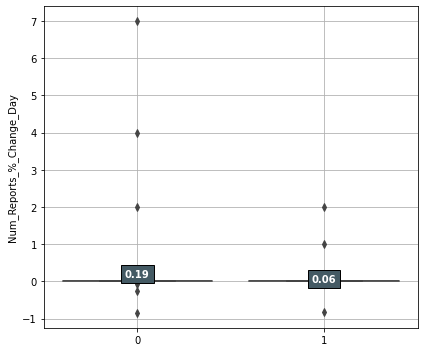

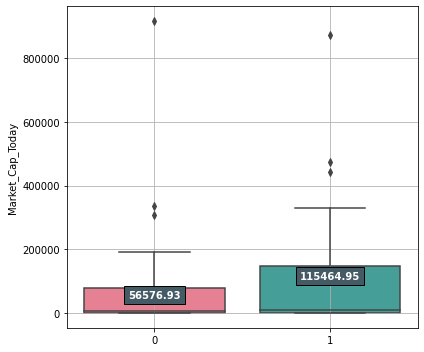

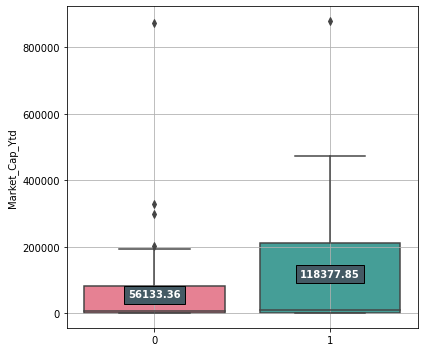

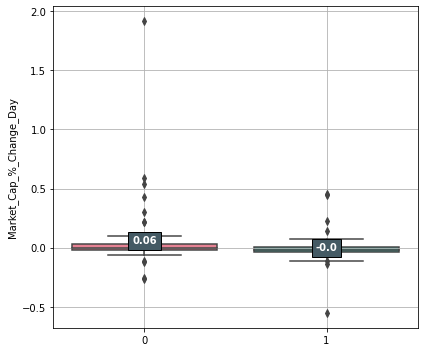

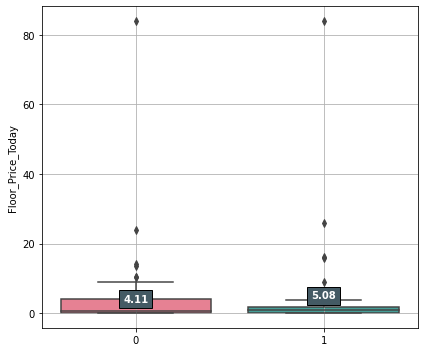

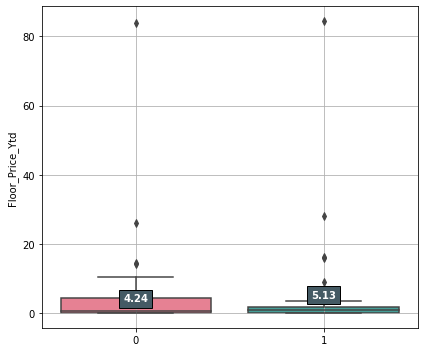

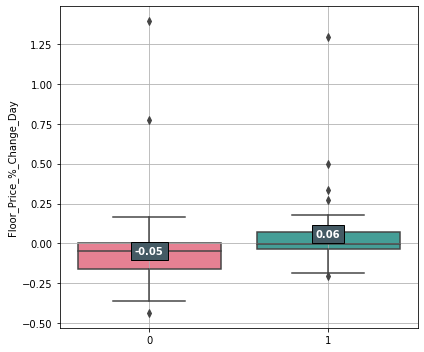

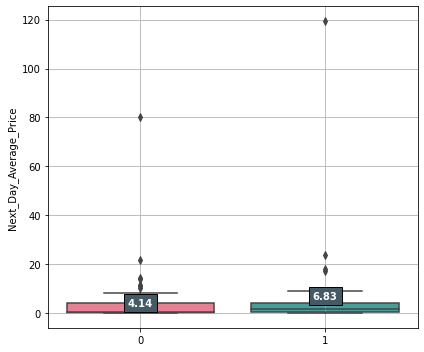

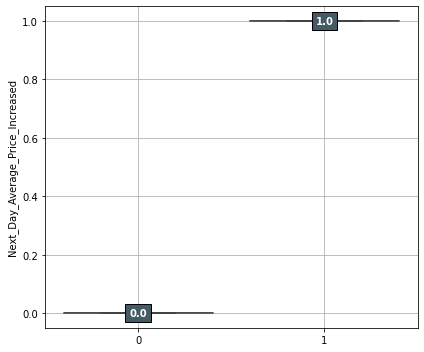

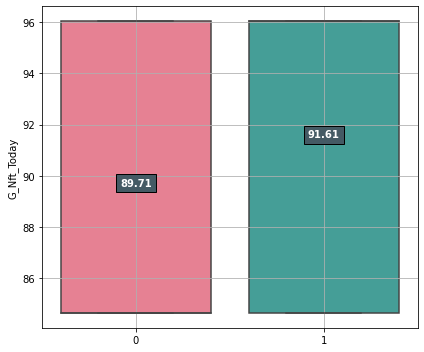

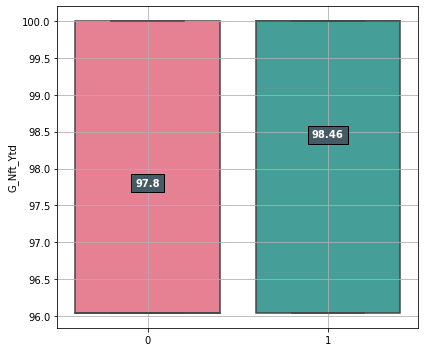

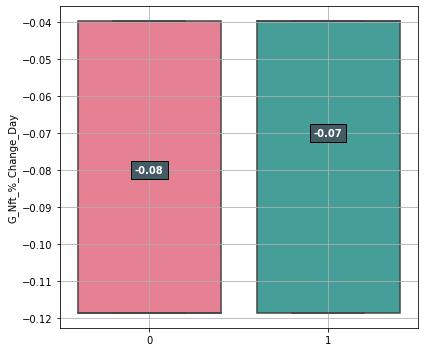

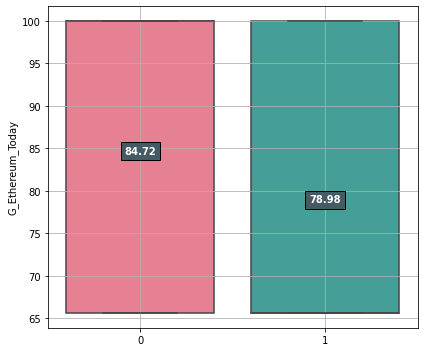

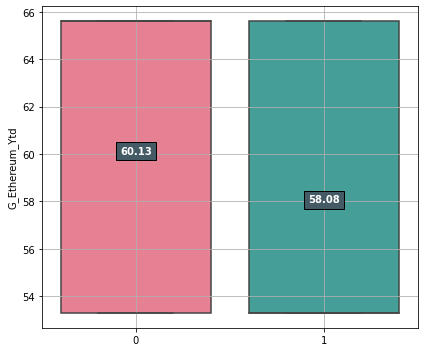

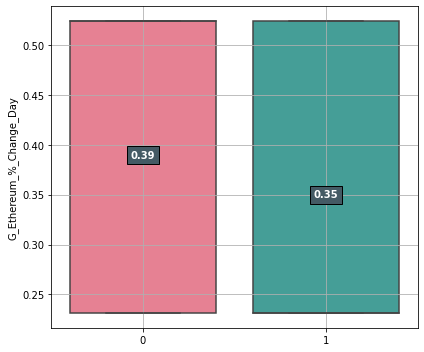

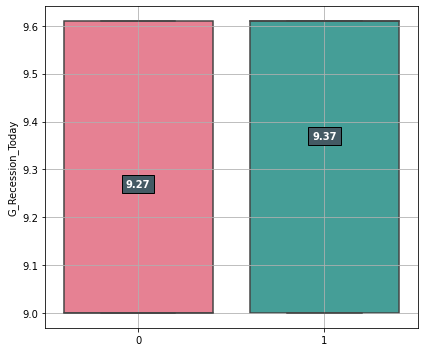

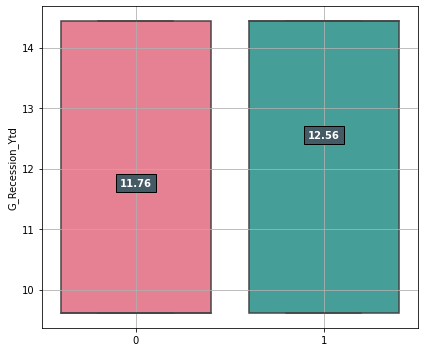

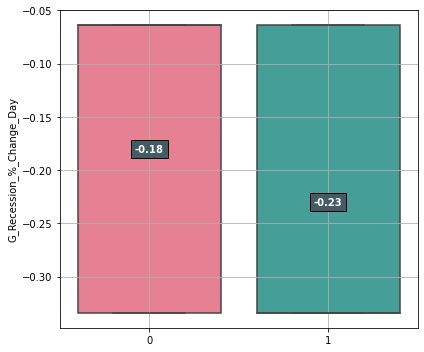

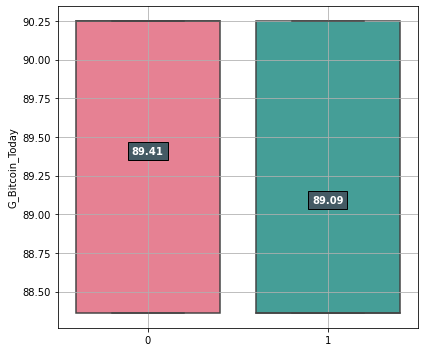

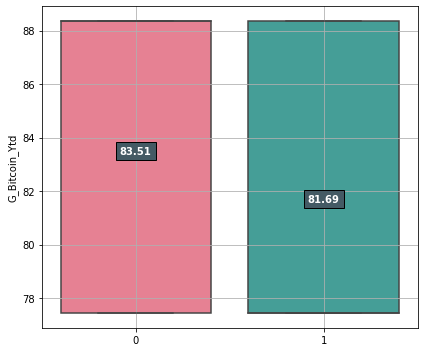

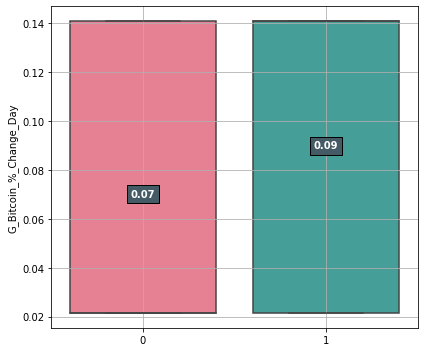

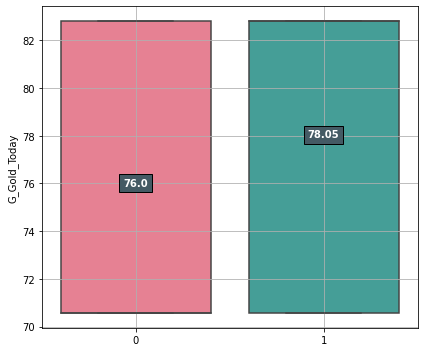

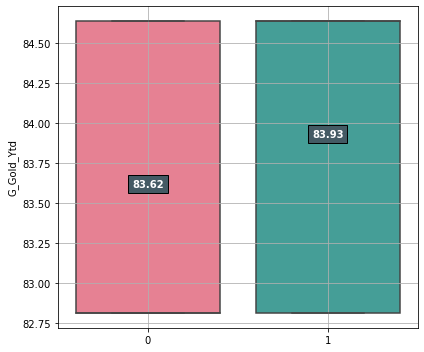

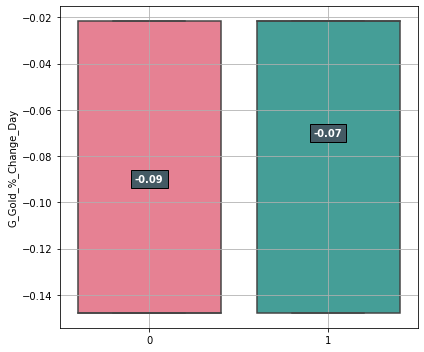

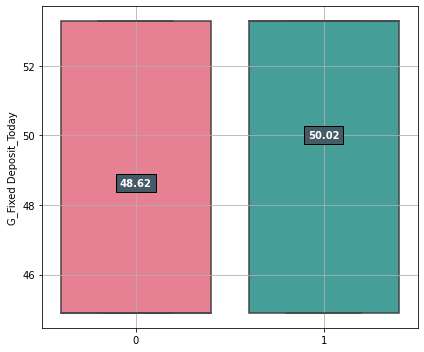

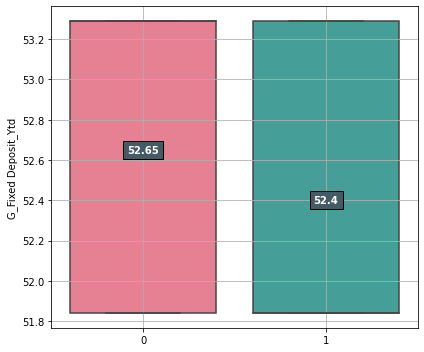

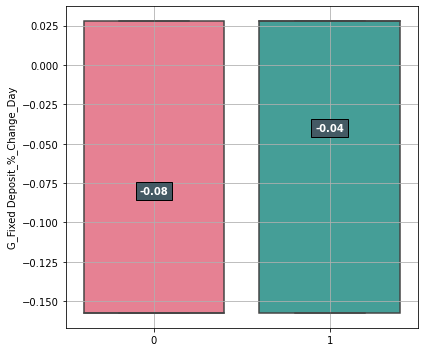

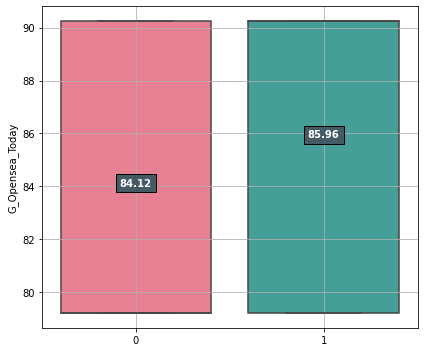

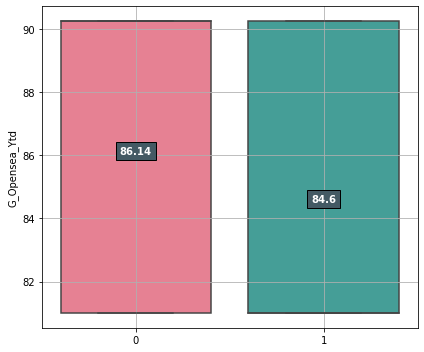

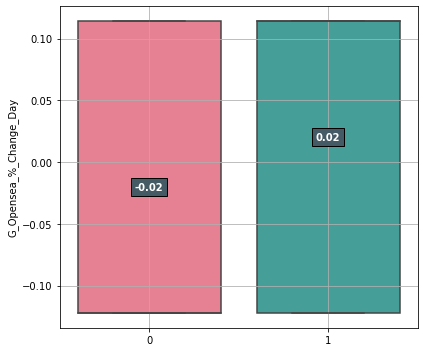

In [10]:
from collections import OrderedDict
import seaborn as sns
def plot_multiple_boxplots(data: pd.DataFrame, grouped_col: str, target_col: str,
                           palette: str = "husl"):
    plt.figure(figsize=(6, 5))

    means: dict = data.groupby([grouped_col])[target_col].mean().to_dict(OrderedDict)
    counter: int = 0

    bp = sns.boxplot(x=grouped_col, y=target_col, data=data, palette=palette, order=list(means.keys()))
    bp.set(xlabel='', ylabel=f"{target_col.title()}")
    ax = bp.axes

    for k, v in means.items():
        # every 4th line at the interval of 6 is median line
        # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
        mean = round(v, 2)
        ax.text(
            counter,
            mean,
            f'{mean}',
            ha='center',
            va='center',
            fontweight='bold',
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))
        counter += 1
    bp.figure.tight_layout()
    plt.grid()
    plt.show()

# box plot to see detailed relationship between the label and rest of the columns
for i in df.columns:
  if i != "next_day_price_increased":
    plot_multiple_boxplots(data=df, grouped_col='next_day_average_price_increased', target_col=i, palette='husl')
#plot_multiple_boxplots(data=df, grouped_col='next_day_price_increased', target_col='floor_price', palette='husl')

In [11]:
# Model with just historical prices
# Model with historical prices + twitter
# Model with historical prices + twitter + google trends

In [12]:
test_set_weight = 0.2
x_train, x_test, y_train, y_test = train_test_split(df.drop(['next_day_average_price_increased', 'next_day_average_price'], axis=1), df['next_day_average_price_increased'], test_size=test_set_weight)

In [13]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Create an SFS object
ensemble_search = RandomForestClassifier()
sfs = SFS(estimator=ensemble_search,       # Use logistic regression as our classifier
          k_features=(1, 10),  # Consider any feature combination between 1 and 4
          forward=True,       # Set forward to True when we want to perform SFS
          scoring='accuracy', # The metric to use to evaluate the classifier is accuracy 
          cv=5)               # The number of cross-validations to perform is 5

# Train SFS with our dataset
sfs = sfs.fit(x_train, y_train)

# Print the results
print('Best accuracy score: %.2f' % sfs.k_score_)   # k_score_ shows the best score 
print('Best subset (indices):', sfs.k_feature_idx_) # k_feature_idx_ shows the index of features 
                                                    # that yield the best score
print('Best subset (corresponding names):', sfs.k_feature_names_) # k_feature_names_ shows the feature names 

Best accuracy score: 0.87
Best subset (indices): (1, 32, 48, 50)
Best subset (corresponding names): ('t_retweets_today', 't_unique_verified_tweeters_%_change_day', 'one_day_average_price_today', 'one_day_average_price_%_change_day')


In [14]:
sfs_results = pd.DataFrame.from_dict(sfs.subsets_).T 
sfs_results

feature_idx  \
1                                      (48,)   
2                                   (32, 48)   
3                               (32, 48, 50)   
4                            (1, 32, 48, 50)   
5                        (1, 32, 48, 50, 82)   
6                    (1, 30, 32, 48, 50, 82)   
7                (1, 30, 31, 32, 48, 50, 82)   
8           (1, 30, 31, 32, 48, 50, 82, 102)   
9       (1, 24, 30, 31, 32, 48, 50, 82, 102)   
10  (1, 24, 29, 30, 31, 32, 48, 50, 82, 102)   

                                            cv_scores avg_score  \
1                 [0.75, 0.9375, 0.6875, 0.8125, 0.6]    0.7575   
2   [0.8125, 0.9375, 0.75, 0.8125, 0.7333333333333...  0.809167   
3                  [0.875, 0.9375, 0.75, 0.8125, 0.8]     0.835   
4                  [0.9375, 0.875, 0.875, 0.875, 0.8]    0.8725   
5   [0.9375, 0.875, 0.875, 0.8125, 0.7333333333333...  0.846667   
6   [0.875, 0.875, 0.8125, 0.8125, 0.7333333333333...  0.821667   
7                   [0.875, 0.875, 0.8125, 0.75, 0.8]    0.8225   
8                 [0.875, 0.875, 0.6875, 0.8125, 0.8]      0.81   
9                   [0.875, 0.875, 0.75, 0.8125, 0.8]    0.8225   
10                  [0.875, 0.875, 0.8125, 0.75, 0.8]    0.8225   

                                        feature_names  
1                      (one_day_average_price_today,)  
2   (t_unique_verified_tweeters_%_change_day, one_...  
3   (t_unique_verified_tweeters_%_change_day, one_...  
4   (t_retweets_today, t_unique_verified_tweeters_...  
5   (t_retweets_today, t_unique_verified_tweeters_...  
6   (t_retweets_today, t_quotes_%_change_day, t_un...  
7   (t_retweets_today, t_quotes_%_change_day, t_un...  
8   (t_retweets_today, t_quotes_%_change_day, t_un...  
9   (t_retweets_today, t_sent_weak_neg_ytd, t_quot...  
10  (t_retweets_today, t_sent_weak_neg_ytd, t_like...

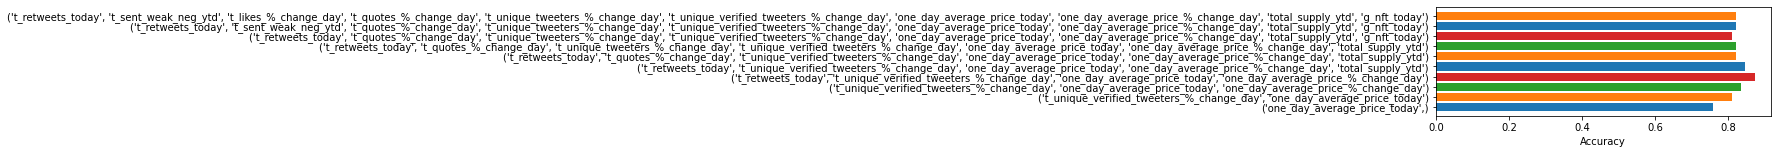

In [15]:
# Create a horizontal bar chart for visualizing 
# the performance of each subset of features
fig, ax = plt.subplots(figsize=(6,2))
y_pos = np.arange(len(sfs_results))
ax.barh(y_pos, 
        sfs_results['avg_score'], 
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_yticks(y_pos)
ax.set_yticklabels(sfs_results['feature_names'])
ax.set_xlabel('Accuracy')
plt.show()

In [16]:
from sklearn.feature_selection import f_classif
f_value = f_classif(x_train, y_train)
traning_col = x_train.columns
# Print the name and F-value of each feature
for feature in zip(list(traning_col), f_value[0]):
    print(feature)

('t_tweets_today', 1.1340866288980067)
('t_retweets_today', 1.3587623751919031)
('t_replies_today', 1.6644428412984482)
('t_likes_today', 2.084639186984473)
('t_quotes_today', 2.083559006301493)
('t_unique_tweeters_today', 0.7784348866482317)
('t_unique_verified_tweeters_today', 5.37350808222589)
('t_followers_today', 4.951004844479576)
('t_sent_str_pos_today', 0.004926648962578982)
('t_sent_weak_pos_today', 2.9950055254105994)
('t_sent_neutral_today', 1.728516697509241)
('t_sent_weak_neg_today', 0.38357337991102863)
('t_sent_str_neg_today', 1.4842235257795613)
('t_tweets_ytd', 2.0688318371647916)
('t_retweets_ytd', 1.6777730560986515)
('t_replies_ytd', 0.16239979266583388)
('t_likes_ytd', 0.8761173096575982)
('t_quotes_ytd', 1.0592902499103127)
('t_unique_tweeters_ytd', 0.9844329814661458)
('t_unique_verified_tweeters_ytd', 0.8761897315482083)
('t_followers_ytd', 3.341950020638235)
('t_sent_str_pos_ytd', 0.18191837064866695)
('t_sent_weak_pos_ytd', 2.980656413211477)
('t_sent_neutral_

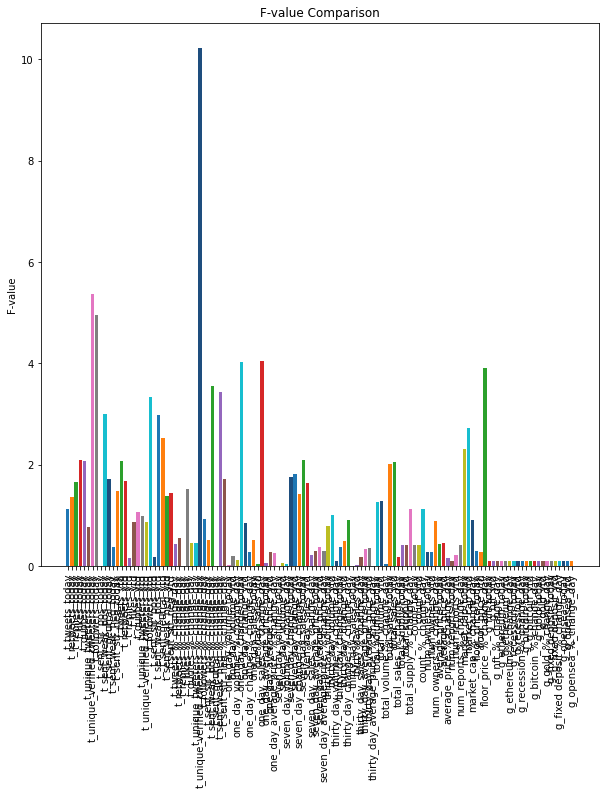

In [17]:
plt.figure(figsize=(10,10))
plt.bar(x=traning_col, height=f_value[0], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1e4e7e'])
plt.xticks(rotation='vertical')
plt.ylabel('F-value')
plt.title('F-value Comparison')
plt.show()

In [18]:
from sklearn.feature_selection import mutual_info_classif
MI_score = mutual_info_classif(x_train, y_train, random_state=0)

# Print the name and mutual information score of each feature
for feature in zip(traning_col, MI_score):
    print(feature)

('t_tweets_today', 0.10547052229696297)
('t_retweets_today', 0.0)
('t_replies_today', 0.08052553449486033)
('t_likes_today', 0.0014046938175080736)
('t_quotes_today', 0.0)
('t_unique_tweeters_today', 0.0)
('t_unique_verified_tweeters_today', 0.03477381394202683)
('t_followers_today', 0.020051352858805993)
('t_sent_str_pos_today', 0.10599648975449427)
('t_sent_weak_pos_today', 0.0)
('t_sent_neutral_today', 0.0)
('t_sent_weak_neg_today', 0.0007101834885512304)
('t_sent_str_neg_today', 0.0)
('t_tweets_ytd', 0.0)
('t_retweets_ytd', 0.023760342429672177)
('t_replies_ytd', 0.0)
('t_likes_ytd', 0.0)
('t_quotes_ytd', 0.0)
('t_unique_tweeters_ytd', 0.0)
('t_unique_verified_tweeters_ytd', 0.037112435070380645)
('t_followers_ytd', 0.005470966545359612)
('t_sent_str_pos_ytd', 0.05054891953470486)
('t_sent_weak_pos_ytd', 0.0538856847385587)
('t_sent_neutral_ytd', 0.0)
('t_sent_weak_neg_ytd', 0.006313627689294332)
('t_sent_str_neg_ytd', 0.049967221320162736)
('t_tweets_%_change_day', 0.0)
('t_retwee

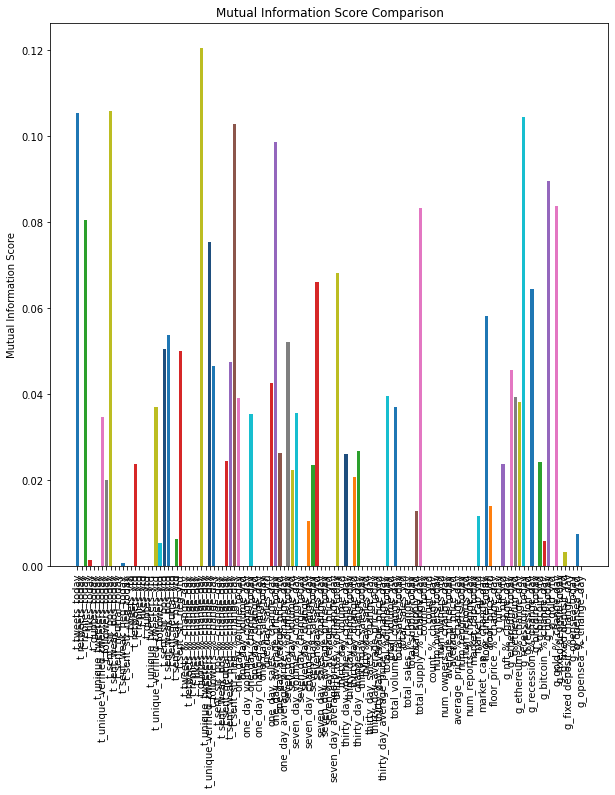

In [19]:
plt.figure(figsize=(10,10))
plt.bar(x=traning_col, height=MI_score, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1e4e7e'])
plt.xticks(rotation='vertical')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Comparison')

plt.show()

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [34]:
print(type(list(sfs_results['feature_names'][4])))

def get_n_largest(N: int, test_list: list, features: list):
  n_best = sorted(range(len(test_list)), key = lambda sub: test_list[sub])[-N:]
  res = list()
  for i in n_best:
    res.append(features[i]) 
  return res

F_value_best = get_n_largest(8, f_value[0], traning_col)
MI_best = get_n_largest(8, MI_score, traning_col)

selected_feature = list(set(F_value_best + MI_best + list(sfs_results['feature_names'][8]) ))
print(len(selected_feature))
print(F_value_best)
print(MI_best)
print(list(sfs_results['feature_names'][8]))
print(selected_feature)

<class 'list'>
21
['t_sent_weak_neg_%_change_day', 't_sent_weak_pos_%_change_day', 'floor_price_%_change_day', 'one_day_change_today', 'one_day_sales_%_change_day', 't_followers_today', 't_unique_verified_tweeters_today', 't_unique_verified_tweeters_%_change_day']
['g_gold_%_change_day', 'g_gold_today', 'one_day_average_price_today', 't_sent_str_neg_%_change_day', 'g_recession_today', 't_tweets_today', 't_sent_str_pos_today', 't_quotes_%_change_day']
['t_retweets_today', 't_quotes_%_change_day', 't_unique_tweeters_%_change_day', 't_unique_verified_tweeters_%_change_day', 'one_day_average_price_today', 'one_day_average_price_%_change_day', 'total_supply_ytd', 'g_nft_today']
['total_supply_ytd', 't_sent_weak_neg_%_change_day', 'one_day_change_today', 't_retweets_today', 't_unique_verified_tweeters_%_change_day', 't_unique_tweeters_%_change_day', 'one_day_average_price_%_change_day', 't_quotes_%_change_day', 't_unique_verified_tweeters_today', 't_sent_str_neg_%_change_day', 'g_gold_%_chan

In [35]:
print(df.shape)
print(len(selected_feature))

(99, 125)
21


In [23]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
def ShowPerformance(predicted_value, actual_value):
    accuracy = accuracy_score(actual_value , predicted_value) * 100
    precision = precision_score(actual_value , predicted_value) * 100
    recall = recall_score(actual_value , predicted_value) * 100
    f1 = f1_score(actual_value , predicted_value, average='weighted')
    print('Accuracy is {:.4f}%\n Precision is {:.4f}%\n Recall is {:.4f}%\nF1 Score is {:.4f}\n'.format(accuracy, precision, recall, f1))

In [24]:
reduced_x_train = x_train[selected_feature]
reduced_y_train = y_train
reduced_x_test = x_test[selected_feature]
reduced_y_test = y_test

In [25]:
lr = LogisticRegression()
lr.fit(reduced_x_train,reduced_y_train)
lr_prediction=lr.predict(reduced_x_test)
ShowPerformance(lr_prediction, reduced_y_test)

Accuracy is 55.0000%
 Precision is 0.0000%
 Recall is 0.0000%
F1 Score is 0.3903



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
clf = LinearSVC(penalty='l2', loss='squared_hinge',
                dual=True, tol=0.0001, C=100, multi_class='ovr',
                fit_intercept=True, intercept_scaling=1, class_weight=None,verbose=0
                , random_state=0, max_iter=1000)
clf.fit(reduced_x_train,reduced_y_train)
clf_prediction=clf.predict(reduced_x_test)
ShowPerformance(clf_prediction, reduced_y_test)

Accuracy is 55.0000%
 Precision is 50.0000%
 Recall is 33.3333%
F1 Score is 0.5320



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [27]:
mod_dt = DecisionTreeClassifier(max_depth = 10, random_state = 1)
mod_dt.fit(reduced_x_train,reduced_y_train)
mod_dt_prediction=mod_dt.predict(reduced_x_test)
#print("The accuracy of the Decision Tree is","{:.3f}".format(metrics.accuracy_score(mod_dt_prediction,y_test)))
ShowPerformance(mod_dt_prediction, reduced_y_test)

Accuracy is 55.0000%
 Precision is 50.0000%
 Recall is 33.3333%
F1 Score is 0.5320



In [28]:
nb_classify= GaussianNB()
nb_classify.fit(reduced_x_train, reduced_y_train)
nb_classify_prediction=nb_classify.predict(reduced_x_test)
ShowPerformance(nb_classify_prediction, reduced_y_test)

Accuracy is 50.0000%
 Precision is 0.0000%
 Recall is 0.0000%
F1 Score is 0.3667



In [29]:
ensemble_search = RandomForestClassifier()
ensemble_search.fit(reduced_x_train, reduced_y_train)
ensemble_search_prediction=ensemble_search.predict(reduced_x_test)
#print("The accuracy of the Random Forest is","{:.3f}".format(metrics.accuracy_score(ensemble_search_prediction,y_test)))
ShowPerformance(ensemble_search_prediction, reduced_y_test)

Accuracy is 55.0000%
 Precision is 50.0000%
 Recall is 22.2222%
F1 Score is 0.5051



In [30]:
#add xgboost
import xgboost as xgb
boost = xgb.XGBClassifier()
boost.fit(reduced_x_train, reduced_y_train)
boost_prediction=boost.predict(reduced_x_test)
ShowPerformance(boost_prediction, reduced_y_test)

Accuracy is 45.0000%
 Precision is 33.3333%
 Recall is 22.2222%
F1 Score is 0.4280



#Old Dataset

## covalent bayc

In [ ]:
# data obtained from: curl "https://api.covalenthq.com/v1/1/nft_market/collection/0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D/?quote-currency=USD&format=JSON&to=2022-08-03&from=2022-04-06&key=ckey_4f8eda876b4141c384bc327da5b"
# they stopped updating it after 06 Apr 2022 unfortunately, but we have a year's data.
!wget https://raw.githubusercontent.com/aaronnke/ml_data/main/covalent_bayc.json

--2022-08-11 21:34:10--  https://raw.githubusercontent.com/aaronnke/ml_data/main/covalent_bayc.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1473033 (1.4M) [text/plain]
Saving to: ‘covalent_bayc.json.3’

covalent_bayc.json. 100%[===================>]   1.40M  --.-KB/s    in 0.04s   

2022-08-11 21:34:10 (33.9 MB/s) - ‘covalent_bayc.json.3’ saved [1473033/1473033]



In [ ]:
covalent_bayc = json.load(open('covalent_bayc.json'))['data']['items']

In [ ]:
i = 1
while i < len(covalent_bayc):
  covalent_bayc[i]['target'] = covalent_bayc[i-1]['average_volume_quote_day'] # target is next day's price
  i += 1
covalent_bayc = covalent_bayc[1:] # drop first row as we don't have target for it (next day price)

In [ ]:
# opening_date: day for the row of data (as index)
# volume_wei_day: total trade volume for this collection, in wei (a unit of Eth)
# volume_quote_day: trade volume in the quoted currency, USD
# average_volume_wei_day: volume / transaction_count
# average_volume_quote_day:
# unique_token_ids_sold_count_day: unique tokens sold that day, even if the same token was sold multiple times, still counts as 1 (i believe)
df = pd.DataFrame(covalent_bayc, columns=["opening_date","volume_wei_day","volume_quote_day","average_volume_wei_day","average_volume_quote_day","unique_token_ids_sold_count_day","target"])
df.set_index('opening_date', inplace=True) # we won't train on opening_date

In [ ]:
# data obtained from pytrends.daily_data("BAYC")
!wget https://raw.githubusercontent.com/aaronnke/ml_data/main/google_trends_bayc.csv

--2022-08-11 21:34:11--  https://raw.githubusercontent.com/aaronnke/ml_data/main/google_trends_bayc.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11608 (11K) [text/plain]
Saving to: ‘google_trends_bayc.csv.3’

google_trends_bayc. 100%[===================>]  11.34K  --.-KB/s    in 0s      

2022-08-11 21:34:11 (49.4 MB/s) - ‘google_trends_bayc.csv.3’ saved [11608/11608]



In [ ]:
gtrends_bayc = pd.read_csv('google_trends_bayc.csv',index_col=0)

In [ ]:
# scale from 0-100 to indicate search interest on that day
df["gtrends"] = gtrends_bayc["BAYC"]

In [ ]:
df

volume_wei_day  volume_quote_day average_volume_wei_day  \
opening_date                                                                    
2022-04-05    2053954202000000000000      7.171950e+06  120820835411765000000   
2022-04-04    1685458406060000000000      5.910691e+06  112363893737333000000   
2022-04-03    1134977500000000000000      3.946992e+06  113497750000000000000   
2022-04-02    1130323000000000000000      3.924610e+06  161474714285714000000   
2022-04-01    1998330000000000000000      6.786781e+06  124895625000000000000   
...                              ...               ...                    ...   
2021-05-04     401111837928552000000      1.388962e+06     959597698393666000   
2021-05-03    1160670681779850000000      3.948996e+06     845353737640092000   
2021-05-02    1640600136770050000000      4.950946e+06     894547511870256000   
2021-05-01     589713644024764000000      1.737182e+06     313344125411671000   
2021-04-30        320000000000000000      8.241964e+02     160000000000000000   

              average_volume_quote_day  unique_token_ids_sold_count_day  \
opening_date                                                              
2022-04-05                421879.47000                               11   
2022-04-04                394046.06000                               11   
2022-04-03                394699.25000                               10   
2022-04-02                560658.56000                                6   
2022-04-01                424173.80000                               15   
...                                ...                              ...   
2021-05-04                  3322.87500                              336   
2021-05-03                  2876.18070                              996   
2021-05-02                  2699.53420                             1534   
2021-05-01                   923.05130                             1635   
2021-04-30                   412.09818                                1   

                   target  gtrends  
opening_date                        
2022-04-05    378698.2000    16.17  
2022-04-04    421879.4700    24.01  
2022-04-03    394046.0600    17.15  
2022-04-02    394699.2500    20.65  
2022-04-01    560658.5600    30.68  
...                   ...      ...  
2021-05-04      2439.2693     1.88  
2021-05-03      3322.8750     0.00  
2021-05-02      2876.1807     0.00  
2021-05-01      2699.5342     0.70  
2021-04-30       923.0513     3.35  

[341 rows x 7 columns]

##Linear Model

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.2)

In [ ]:
model = linear_model.LinearRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('MSE:', mean_squared_error(Y_test, Y_pred))
print('R2:', r2_score(Y_test, Y_pred))

Coefficients: [-5.14165253e-17  1.77674330e-02  2.81025203e-15  3.42989466e-04
 -2.51711790e-07  3.20109817e-09]
Intercept: 16003.868603110779
MSE: 2685416348.0145507
R2: 0.8293573118570723


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


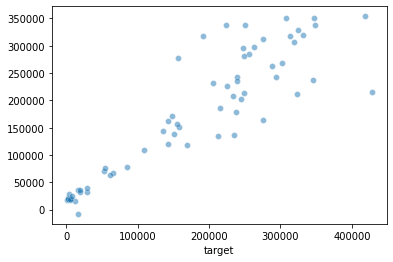

In [ ]:
sns.scatterplot(Y_test, Y_pred, alpha=0.5) # if it's perfect accuracy, this is a diagonal line (if axes units are same)

## Recent Data

In [ ]:
!wget https://raw.githubusercontent.com/aaronnke/ml_data/master/opensea_09_aug_2022.csv

--2022-08-16 14:36:33--  https://raw.githubusercontent.com/aaronnke/ml_data/master/opensea_09_aug_2022.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14214 (14K) [text/plain]
Saving to: ‘opensea_09_aug_2022.csv’

opensea_09_aug_2022 100%[===================>]  13.88K  --.-KB/s    in 0s      

2022-08-16 14:36:33 (94.0 MB/s) - ‘opensea_09_aug_2022.csv’ saved [14214/14214]



In [ ]:
!wget https://raw.githubusercontent.com/aaronnke/ml_data/master/opensea_10_aug_2022.csv

--2022-08-16 14:36:34--  https://raw.githubusercontent.com/aaronnke/ml_data/master/opensea_10_aug_2022.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14303 (14K) [text/plain]
Saving to: ‘opensea_10_aug_2022.csv’

opensea_10_aug_2022 100%[===================>]  13.97K  --.-KB/s    in 0s      

2022-08-16 14:36:34 (76.9 MB/s) - ‘opensea_10_aug_2022.csv’ saved [14303/14303]



In [ ]:
!wget https://raw.githubusercontent.com/aaronnke/ml_data/master/twitter_search_aggregate.csv

--2022-08-16 14:36:36--  https://raw.githubusercontent.com/aaronnke/ml_data/master/twitter_search_aggregate.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9548 (9.3K) [text/plain]
Saving to: ‘twitter_search_aggregate.csv’

twitter_search_aggr 100%[===================>]   9.32K  --.-KB/s    in 0s      

2022-08-16 14:36:36 (57.0 MB/s) - ‘twitter_search_aggregate.csv’ saved [9548/9548]



In [ ]:
opensea_data_yesterday = pd.read_csv('opensea_09_aug_2022.csv')
opensea_data_today = pd.read_csv('opensea_10_aug_2022.csv')
twitter_data = pd.read_csv('twitter_search_aggregate.csv') # the search term is listed in column search_term, we may want to add more search terms for each collection

In [ ]:
opensea_data_today.set_index("collection", inplace=True)
opensea_data_yesterday.set_index("collection", inplace=True)
twitter_data.set_index("collection", inplace=True)
opensea_data_yesterday = pd.concat([opensea_data_yesterday, twitter_data], axis=1)
opensea_data_yesterday["next_day_average_price"] = opensea_data_today["one_day_average_price"] # this will be our target column
df = opensea_data_yesterday
df["next_day_price_increased"] = df["next_day_average_price"] > df["one_day_average_price"]
df.rename(columns={
    "tweet_count_2022-08-09": "twitter_tweets_1_day_ago",
    "retweet_count_2022-08-09": "twitter_retweets_1_day_ago",
    "reply_count_2022-08-09": "twitter_replies_1_day_ago",
    "like_count_2022-08-09": "twitter_likes_1_day_ago",
    "quote_count_2022-08-09": "twitter_quotes_1_day_ago",
    "sentiment_strong_pos_count_2022-08-09": "twitter_sentiment_strong_pos_1_day_ago",
    "sentiment_weak_pos_count_2022-08-09": "twitter_sentiment_weak_pos_1_day_ago",
    "sentiment_neutral_count_2022-08-09": "twitter_sentiment_neutral_1_day_ago",
    "sentiment_strong_neg_count_2022-08-09": "twitter_sentiment_strong_neg_1_day_ago",
    "sentiment_weak_neg_count_2022-08-09": "twitter_sentiment_weak_neg_1_day_ago",
    "tweet_count_2022-08-08": "twitter_tweets_2_day_ago",
    "retweet_count_2022-08-08": "twitter_retweets_2_day_ago",
    "reply_count_2022-08-08": "twitter_replies_2_day_ago",
    "like_count_2022-08-08": "twitter_likes_2_day_ago",
    "quote_count_2022-08-08": "twitter_quotes_2_day_ago",
    "sentiment_strong_pos_count_2022-08-08": "twitter_sentiment_strong_pos_2_day_ago",
    "sentiment_weak_pos_count_2022-08-08": "twitter_sentiment_weak_pos_2_day_ago",
    "sentiment_neutral_count_2022-08-08": "twitter_sentiment_neutral_2_day_ago",
    "sentiment_strong_neg_count_2022-08-08": "twitter_sentiment_strong_neg_2_day_ago",
    "sentiment_weak_neg_count_2022-08-08": "twitter_sentiment_weak_neg_2_day_ago",
    "tweet_count_2022-08-07": "twitter_tweets_3_day_ago",
    "retweet_count_2022-08-07": "twitter_retweets_3_day_ago",
    "reply_count_2022-08-07": "twitter_replies_3_day_ago",
    "like_count_2022-08-07": "twitter_likes_3_day_ago",
    "quote_count_2022-08-07": "twitter_quotes_3_day_ago",
    "sentiment_strong_pos_count_2022-08-07": "twitter_sentiment_strong_pos_3_day_ago",
    "sentiment_weak_pos_count_2022-08-07": "twitter_sentiment_weak_pos_3_day_ago",
    "sentiment_neutral_count_2022-08-07": "twitter_sentiment_neutral_3_day_ago",
    "sentiment_strong_neg_count_2022-08-07": "twitter_sentiment_strong_neg_3_day_ago",
    "sentiment_weak_neg_count_2022-08-07": "twitter_sentiment_weak_neg_3_day_ago",
    
  }, inplace=True)

In [ ]:
df["twitter_sentiment_strong_pos_3_day_ago"]

collection
rareapepeyachtclub                               15.0
boredapeyachtclub                              1955.0
webaverse-genesis-pass                           67.0
proof-moonbirds                                   1.0
otherdeed                                        46.0
mutant-ape-yacht-club                             2.0
thepotatoz                                        5.0
nftiff                                           46.0
ladyapeclub5668                                   2.0
cryptodickbutts-s3                                0.0
bored-ape-kennel-club                             1.0
clonex                                           60.0
ens                                               4.0
super-cool-world                                 11.0
art-blocks                                       13.0
rakkudos                                         85.0
goblintownwtf                                    19.0
ledger-market-pass-genesis-edition                1.0
8liens           

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df.drop(['next_day_average_price', 'next_day_price_increased', 'floor_price'], axis=1), df['next_day_price_increased'], test_size=0.2)

In [ ]:
X_train

one_day_volume  one_day_change  \
collection                                                                    
8liens                                           204.423939       -0.449707   
azuki                                            150.100000        1.549274   
super-cool-world                                  32.619000       -0.250780   
ladyapeclub5668                                  166.650200       -0.049950   
otherdeed                                        186.136692       -0.408502   
my-beautiful-dark-twisted-fantasy-by-beeble        7.527809       -0.910672   
boredapeyachtclub                                526.403000        0.000000   
nftiff                                            48.800000        0.682759   
cryptodickbutts-s3                                82.756900       -0.878672   
mutant-ape-yacht-club                            196.521601       -0.056975   
bored-and-dangerous                               23.886900       -0.102883   
women-ape-yacht-club                             188.409958        4.993027   
proof-of-narnian-nft-og                          350.224799        0.000000   
mirage-gallery-curated                            14.674000        0.347772   
moodiesbyhanuka                                  301.742473        0.000000   
art-blocks                                       154.249500        0.392975   
subwayrats                                         3.578929       -0.338614   
goblintownwtf                                    155.067500        3.139090   
grails-ii-mint-pass                               72.379949       -0.669123   
care-bears-forever-eth                            26.524680        0.298360   
thepotatoz                                       152.938490       -0.019870   
degods                                            48.557919       -0.487902   
vandal-city                                       20.735573       -0.276141   
digidaigaku                                      323.842024        0.000000   
boonmirds                                          1.710266       -0.711667   
mirandus                                         105.203051        1.136104   
10ktf-stockroom                                   34.404580        0.613632   
bibos                                             13.439295        0.678397   
MV3                                               51.409190       -0.741555   
chromie-squiggle-by-snowfro                       47.500000       -0.147217   
moonbirds-oddities                                46.206600        0.352684   
rakkudos                                          27.880667        0.080802   
art-blocks-playground                             29.564800       -0.746715   
ledger-market-pass-genesis-edition                30.144620       -0.410470   
okay-bears                                        84.186141        1.538319   
ens                                               91.246444        0.077751   
clonex                                           124.070000        0.572114   
lifesajokenft                                     27.663378       -0.519052   
crudeborne-eggs                                  102.843024       -0.012904   
decentraland                                      34.705384       -0.758656   

                                             one_day_sales  \
collection                                                   
8liens                                               882.0   
azuki                                                 18.0   
super-cool-world                                      28.0   
ladyapeclub5668                                       50.0   
otherdeed                                             59.0   
my-beautiful-dark-twisted-fantasy-by-beeble          104.0   
boredapeyachtclub                                      6.0   
nftiff                                                 2.0   
cryptodickbutts-s3                                    24.0   
mutant-ape-yacht-club                       

In [ ]:
model = linear_model.LogisticRegression()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_test)
print(metrics.classification_report(Y_test, Y_pred))

ValueError: ignored

In [ ]:
sns.scatterplot(Y_test, Y_pred, alpha=0.5) # if it's perfect accuracy, this is a diagonal line (if axes units are same)

##Visualization & Data understanding for recent Opensea Data

In [ ]:
import numpy as np
import matplotlib.pyplot as plt # plotting

In [ ]:
# remove non-numeric feature
print(df.shape)
del df['search_term']
print(df.shape)

(50, 54)
(50, 53)


In [ ]:
df

one_day_volume  one_day_change  \
collection                                                                    
rareapepeyachtclub                              1399.089140        4.089683   
boredapeyachtclub                                526.403000        0.000000   
webaverse-genesis-pass                           355.082757       -0.050638   
proof-moonbirds                                  521.758200        2.190031   
otherdeed                                        186.136692       -0.408502   
mutant-ape-yacht-club                            196.521601       -0.056975   
thepotatoz                                       152.938490       -0.019870   
nftiff                                            48.800000        0.682759   
ladyapeclub5668                                  166.650200       -0.049950   
cryptodickbutts-s3                                82.756900       -0.878672   
bored-ape-kennel-club                             79.328400       -0.188590   
clonex                                           124.070000        0.572114   
ens                                               91.246444        0.077751   
super-cool-world                                  32.619000       -0.250780   
art-blocks                                       154.249500        0.392975   
rakkudos                                          27.880667        0.080802   
goblintownwtf                                    155.067500        3.139090   
ledger-market-pass-genesis-edition                30.144620       -0.410470   
8liens                                           204.423939       -0.449707   
boonmirds                                          1.710266       -0.711667   
mirage-gallery-curated                            14.674000        0.347772   
degods                                            48.557919       -0.487902   
women-ape-yacht-club                             188.409958        4.993027   
meebits                                           62.152300        1.718062   
bibos                                             13.439295        0.678397   
azuki                                            150.100000        1.549274   
vandal-city                                       20.735573       -0.276141   
doodles-official                                  26.890000       -0.624389   
goda-mint-pass                                    37.924900       -0.037683   
proof-of-narnian-nft-og                          350.224799        0.000000   
steady-stack-titans-official                      25.751390       -0.711096   
moonbirds-oddities                                46.206600        0.352684   
crudeborne-eggs                                  102.843024       -0.012904   
MV3                                               51.409190       -0.741555   
okay-bears                                        84.186141        1.538319   
digidaigaku                                      323.842024        0.000000   
decentraland                                      34.705384       -0.758656   
care-bears-forever-eth                            26.524680        0.298360   
rags-to-richie-by-alec-monopoly                   28.460201       -0.200201   
art-blocks-playground                             29.564800       -0.746715   
grails-ii-mint-pass                               72.379949       -0.669123   
bored-and-dangerous                               23.886900       -0.102883   
my-beautiful-dark-twisted-fantasy-by-beeble        7.527809       -0.910672   
moodiesbyhanuka                                  301.742473        0.000000   
10ktf-stockroom                                   34.404580        0.613632   
mirandus                                         105.203051        1.136104   
lifesajokenft                                     27.663378       -0.519052   
subwayrats                                         3.578929       -0.338614   
chromie-squiggle-by-snowfro                       47.500000       -0.147217   
sandbox         

In [ ]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 4.0, w_pad = 4.0, h_pad = 1.0)
    plt.show()

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix ', fontsize=15)
    plt.show()
  
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

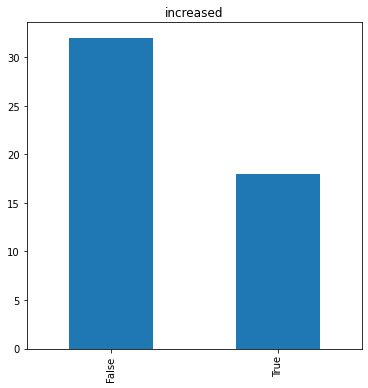

In [ ]:
# see distribution of increased and not-increased collections
fig = plt.figure(figsize=(6,6)) 

df['next_day_price_increased'].value_counts().plot(kind='bar', 
                                     title='increased')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


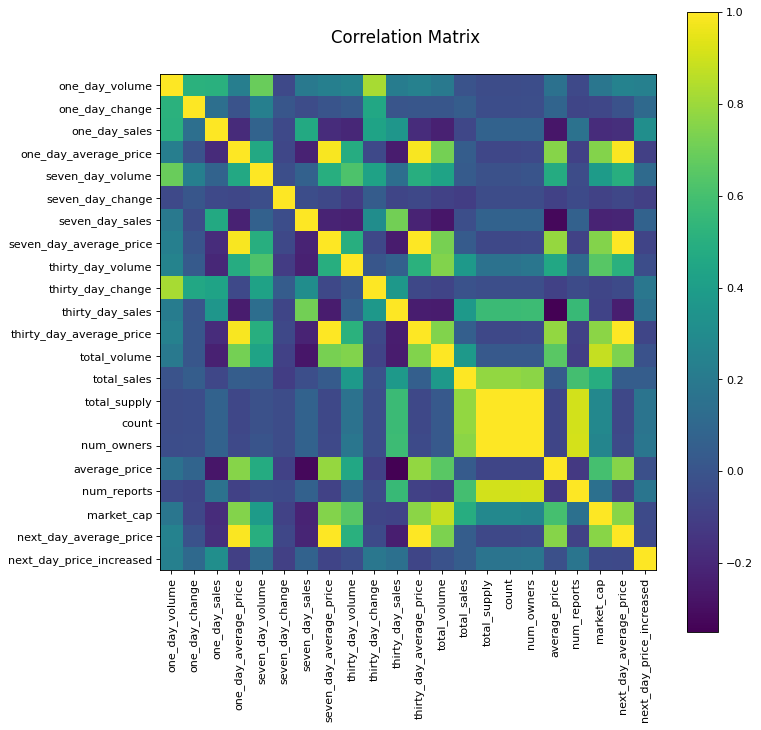

In [ ]:
plotCorrelationMatrix(df, 10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only


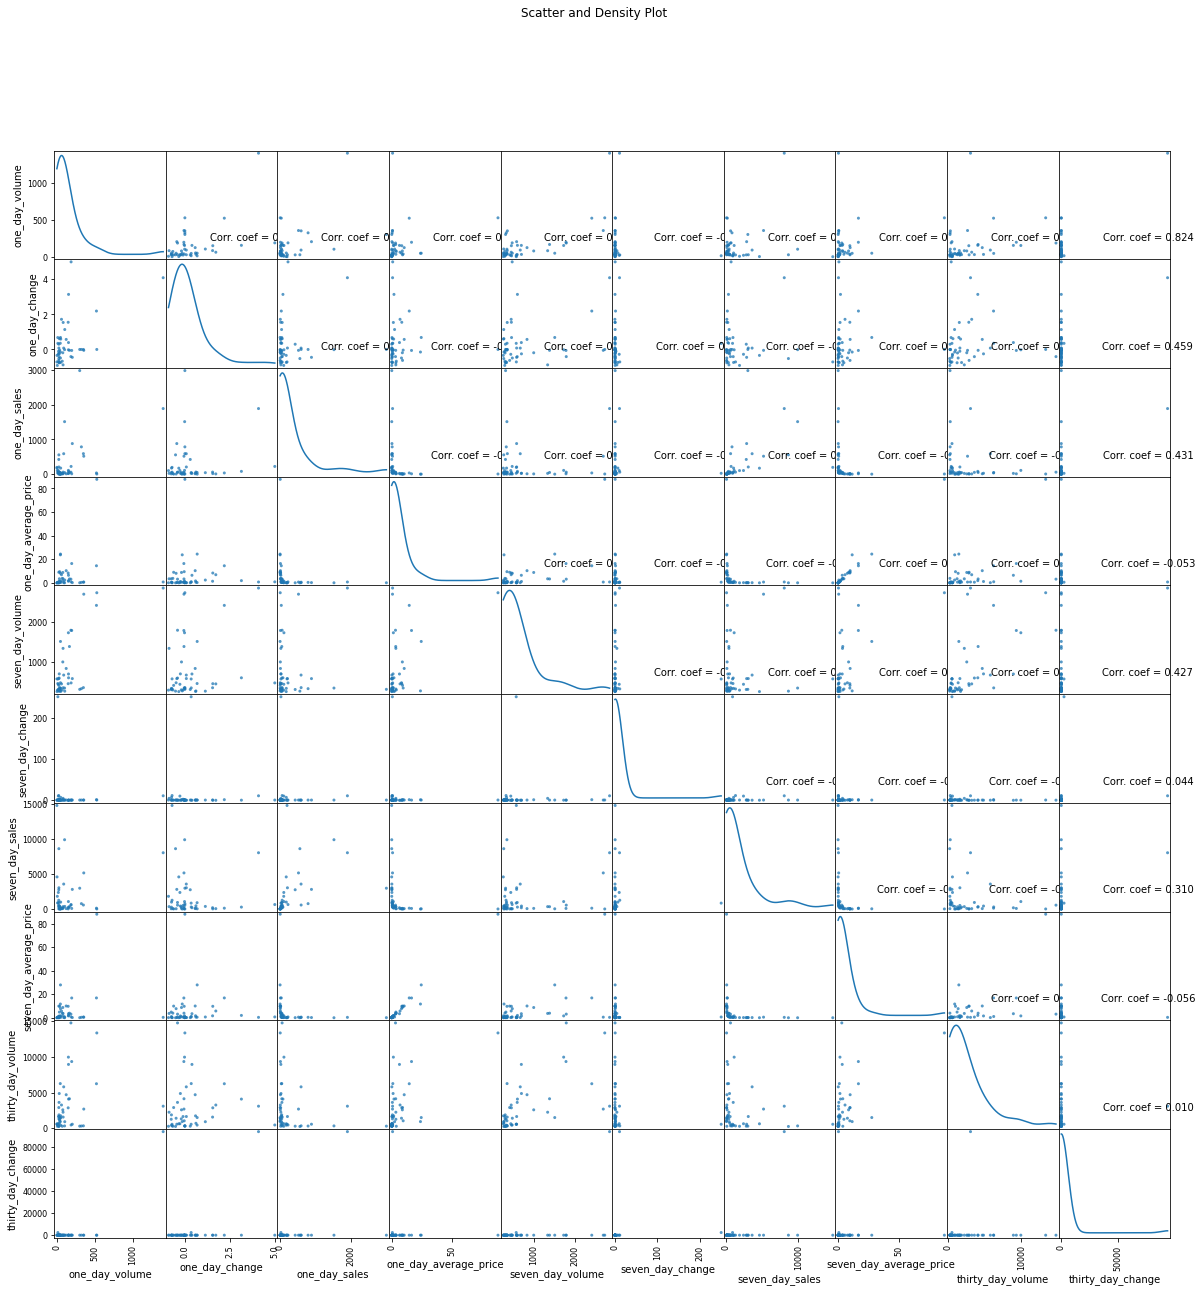

In [ ]:
# scatter matrix of relationship between each two features
plotScatterMatrix(df, 20, 10)

In [ ]:
from collections import OrderedDict
import seaborn as sns
def plot_multiple_boxplots(data: pd.DataFrame, grouped_col: str, target_col: str,
                           palette: str = "husl"):
    plt.figure(figsize=(6, 5))

    means: dict = data.groupby([grouped_col])[target_col].mean().to_dict(OrderedDict)
    counter: int = 0

    bp = sns.boxplot(x=grouped_col, y=target_col, data=data, palette=palette, order=list(means.keys()))
    bp.set(xlabel='', ylabel=f"{target_col.title()}")
    ax = bp.axes

    for k, v in means.items():
        # every 4th line at the interval of 6 is median line
        # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
        mean = round(v, 2)
        ax.text(
            counter,
            mean,
            f'{mean}',
            ha='center',
            va='center',
            fontweight='bold',
            size=10,
            color='white',
            bbox=dict(facecolor='#445A64'))
        counter += 1
    bp.figure.tight_layout()
    plt.grid()
    plt.show()

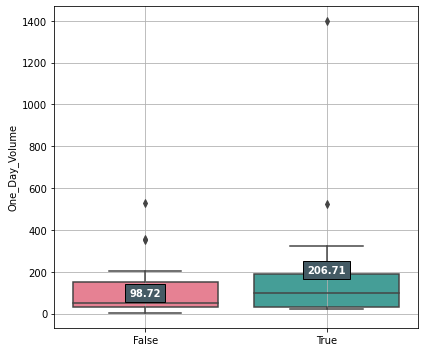

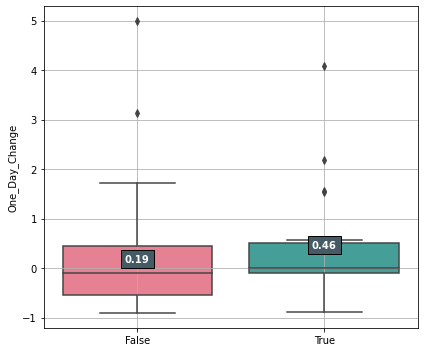

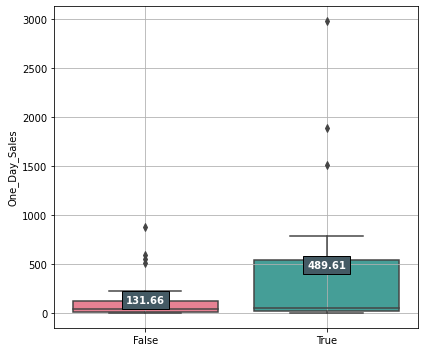

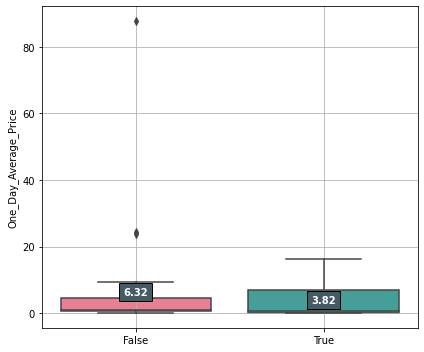

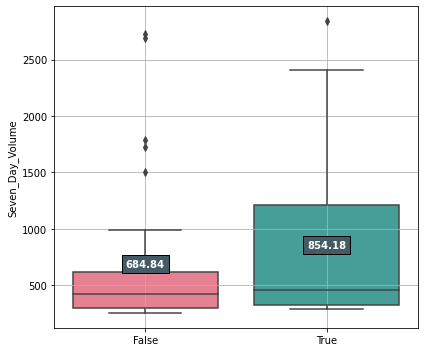

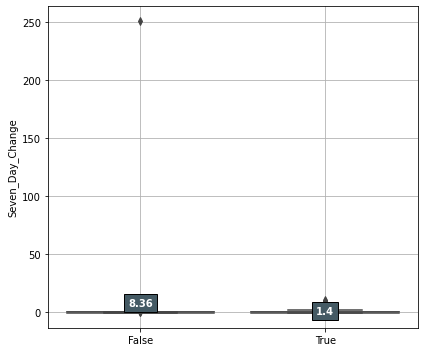

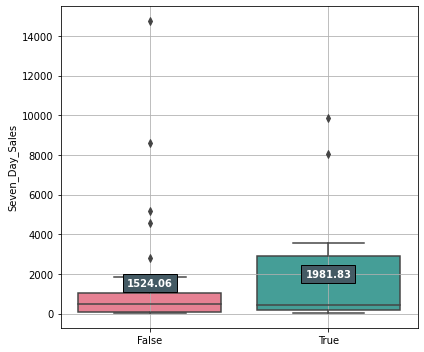

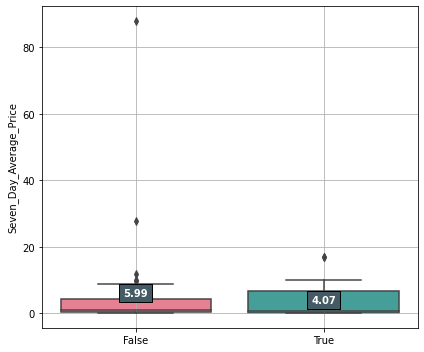

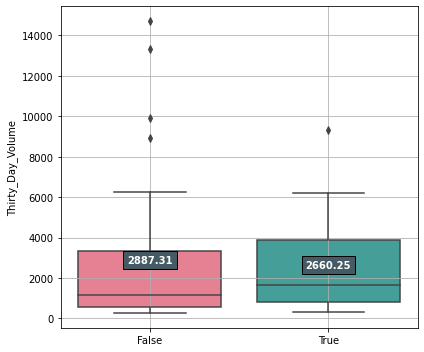

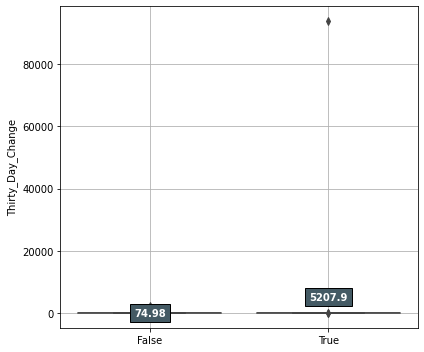

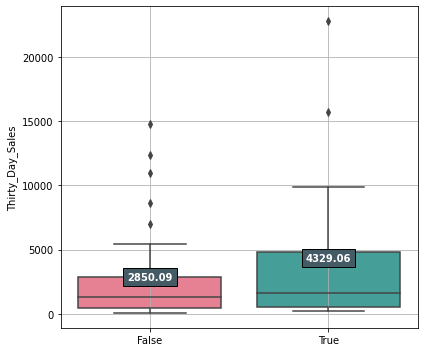

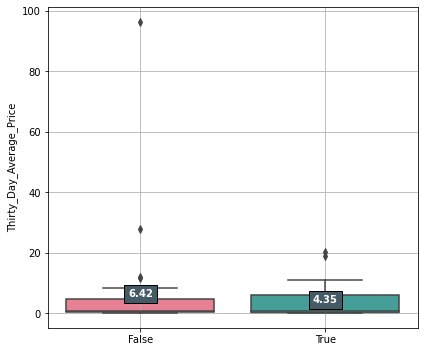

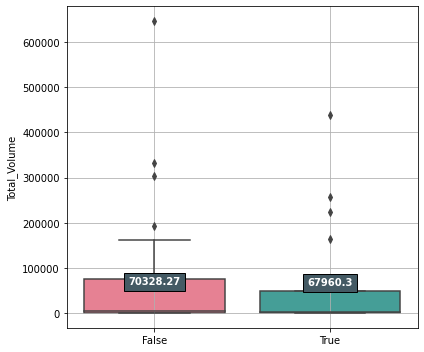

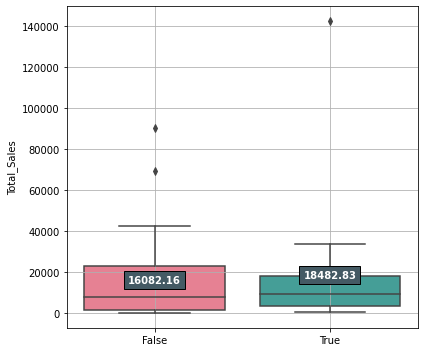

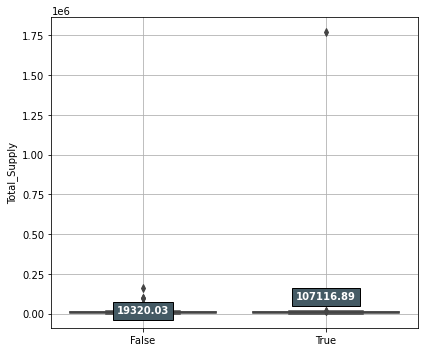

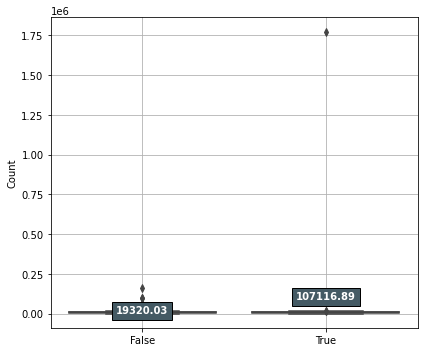

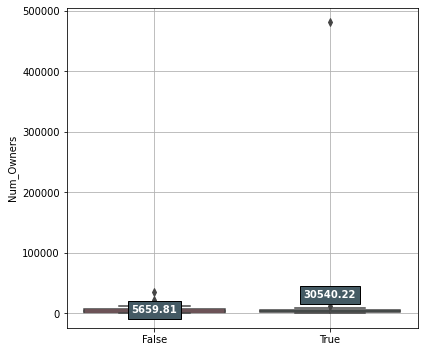

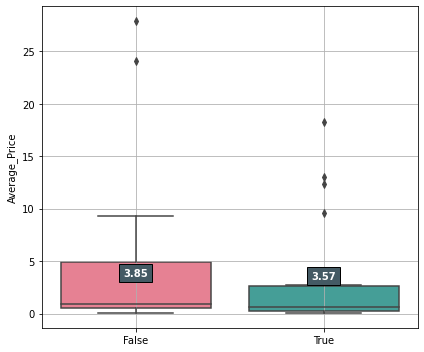

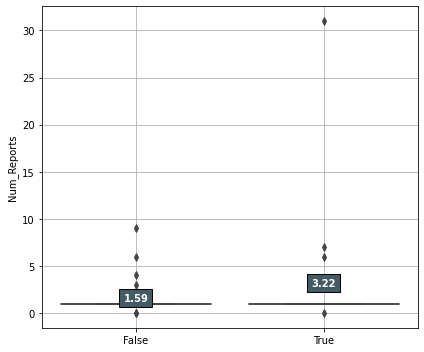

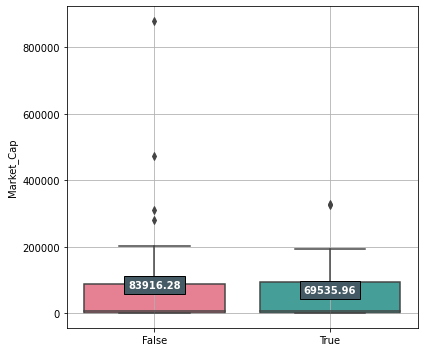

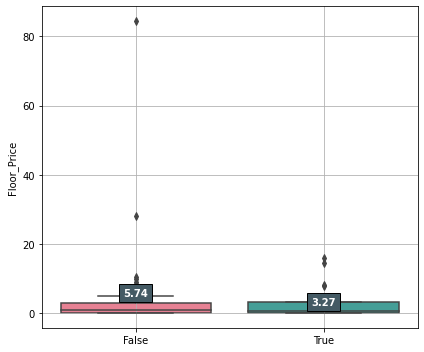

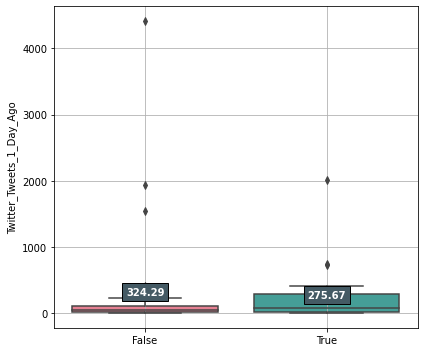

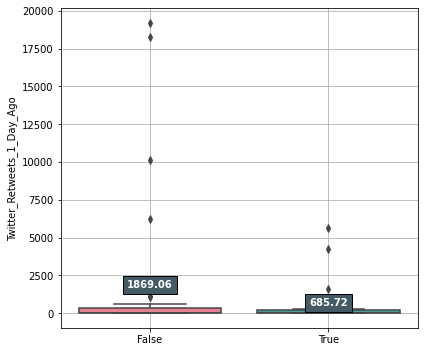

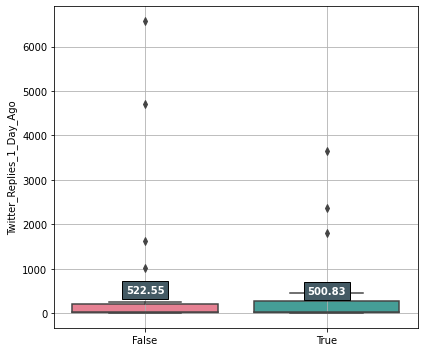

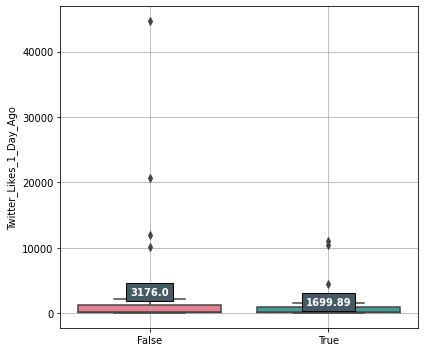

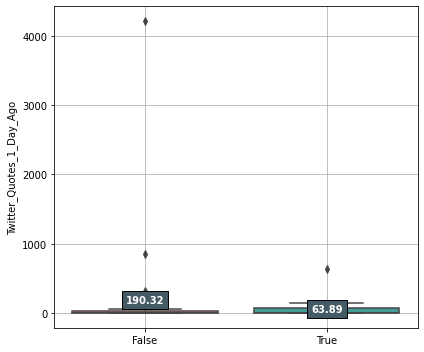

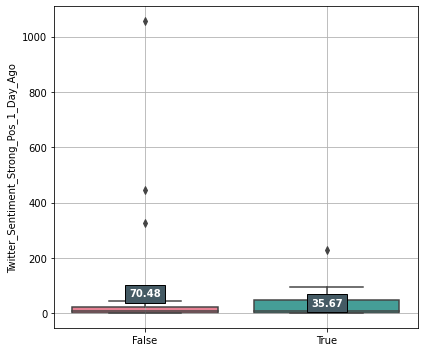

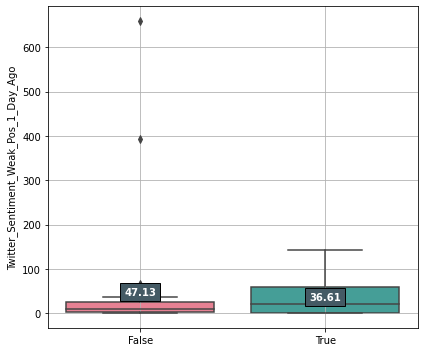

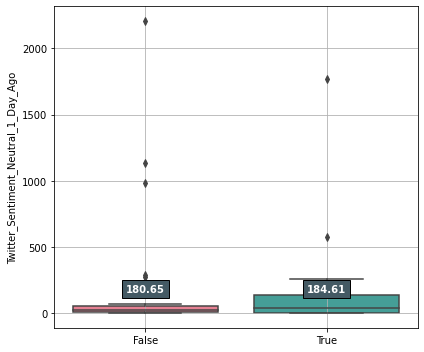

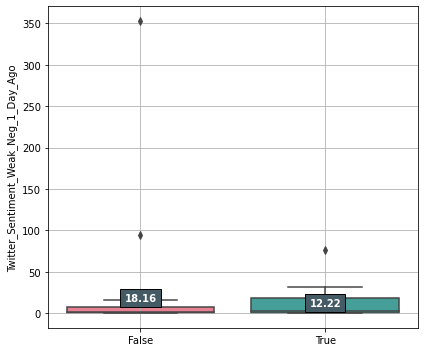

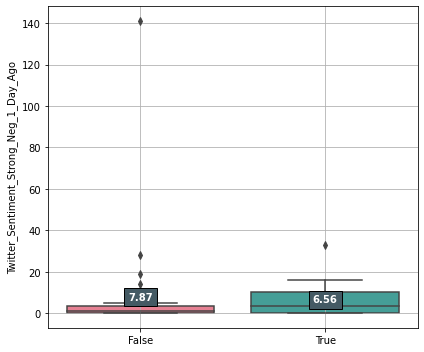

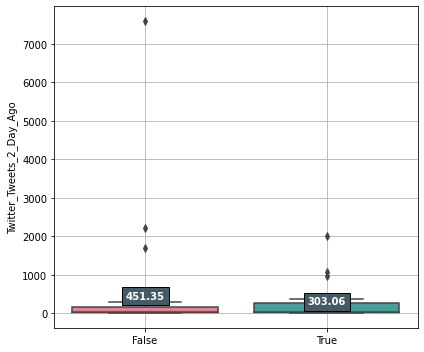

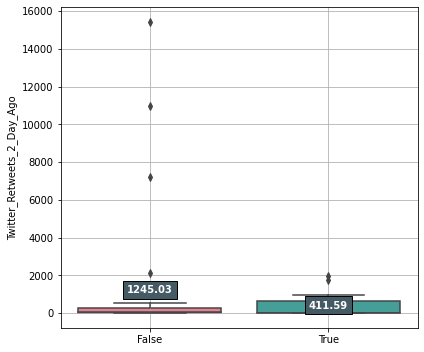

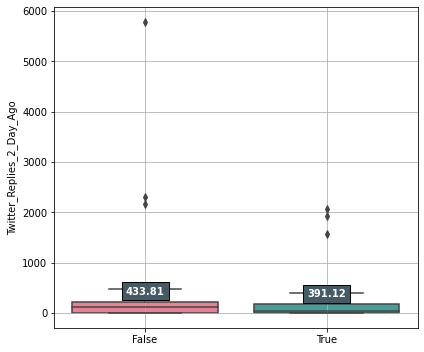

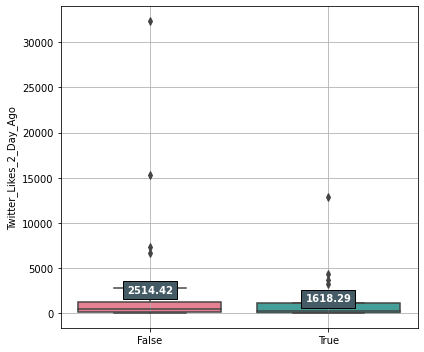

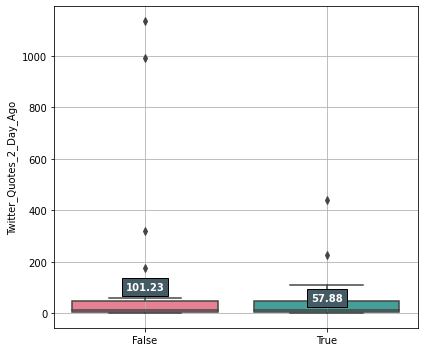

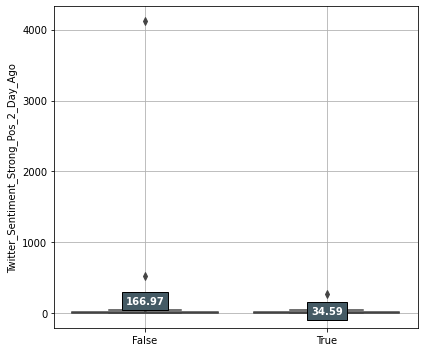

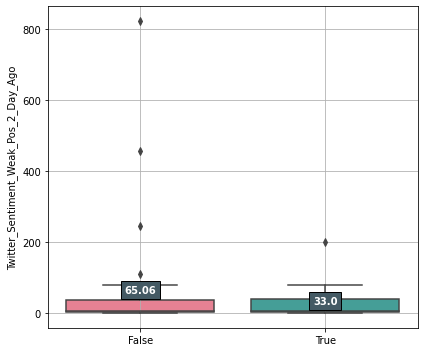

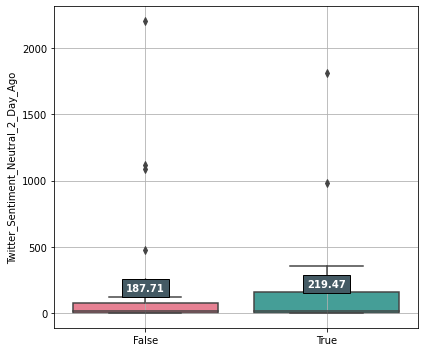

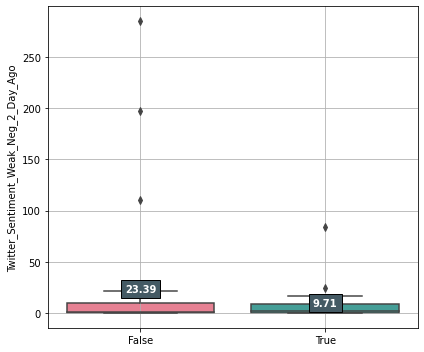

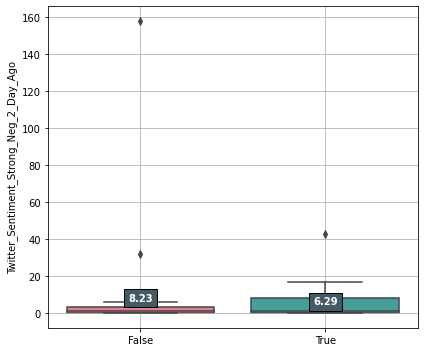

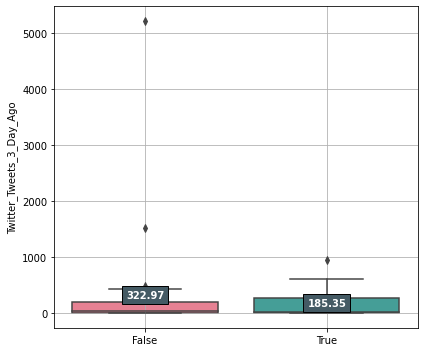

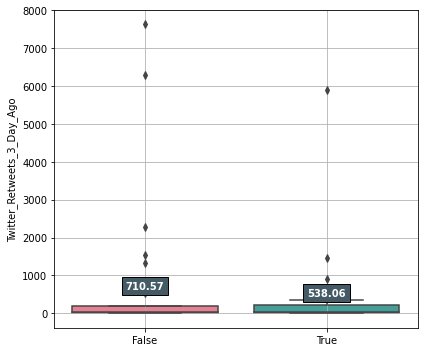

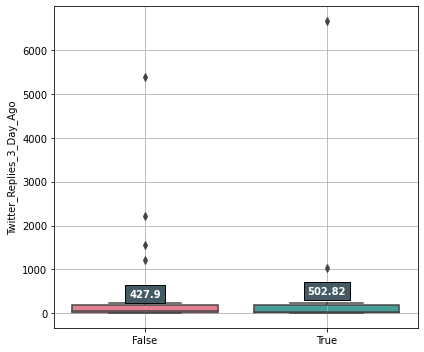

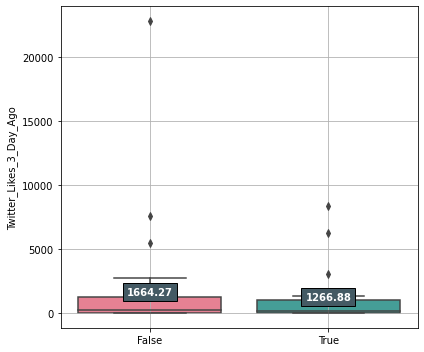

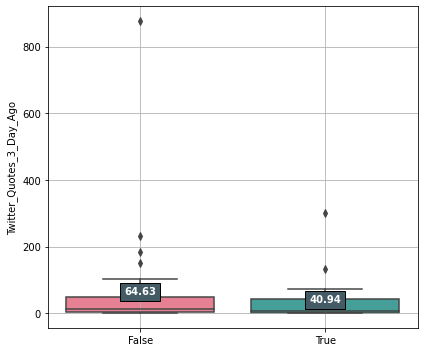

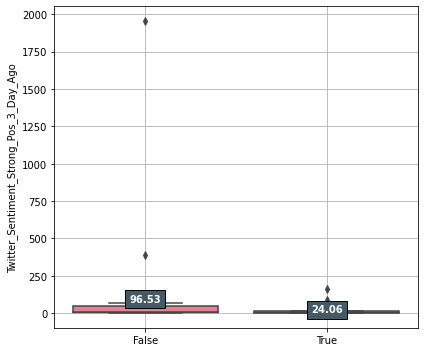

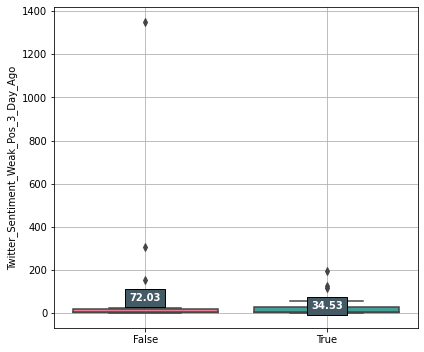

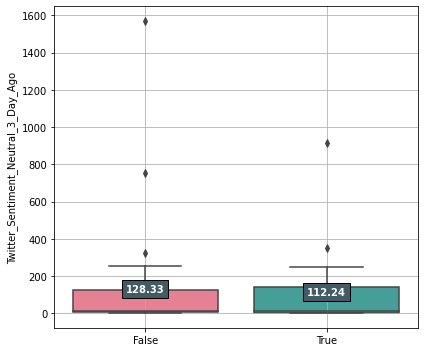

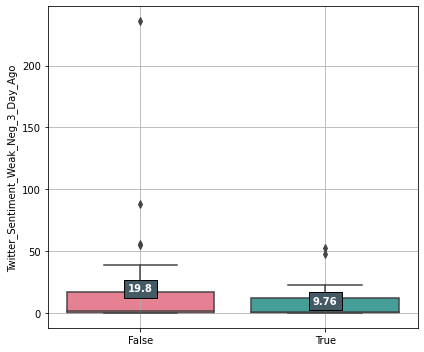

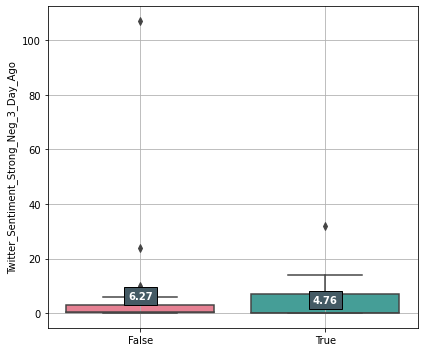

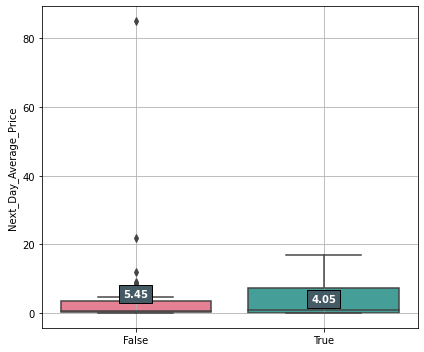

In [ ]:
# box plot to see detailed relationship between the label and rest of the columns
for i in df.columns:
  if i != "next_day_price_increased":
    plot_multiple_boxplots(data=df, grouped_col='next_day_price_increased', target_col=i, palette='husl')
#plot_multiple_boxplots(data=df, grouped_col='next_day_price_increased', target_col='floor_price', palette='husl')

##Feature Selection
reference: https://www.kaggle.com/ar2017/basics-of-feature-selection-with-python

In [ ]:
# Since the df contains nan values, which will affect the feature selection algorithm. Thus drop those rows that contains nans
print(df.shape)
df = df.dropna()
print(df.shape)

(50, 53)
(44, 53)


In [ ]:
traning_col = []
for i in df.columns:
  if i != 'next_day_price_increased': traning_col.append(i)
print(traning_col)

['one_day_volume', 'one_day_change', 'one_day_sales', 'one_day_average_price', 'seven_day_volume', 'seven_day_change', 'seven_day_sales', 'seven_day_average_price', 'thirty_day_volume', 'thirty_day_change', 'thirty_day_sales', 'thirty_day_average_price', 'total_volume', 'total_sales', 'total_supply', 'count', 'num_owners', 'average_price', 'num_reports', 'market_cap', 'floor_price', 'twitter_tweets_1_day_ago', 'twitter_retweets_1_day_ago', 'twitter_replies_1_day_ago', 'twitter_likes_1_day_ago', 'twitter_quotes_1_day_ago', 'twitter_sentiment_strong_pos_1_day_ago', 'twitter_sentiment_weak_pos_1_day_ago', 'twitter_sentiment_neutral_1_day_ago', 'twitter_sentiment_weak_neg_1_day_ago', 'twitter_sentiment_strong_neg_1_day_ago', 'twitter_tweets_2_day_ago', 'twitter_retweets_2_day_ago', 'twitter_replies_2_day_ago', 'twitter_likes_2_day_ago', 'twitter_quotes_2_day_ago', 'twitter_sentiment_strong_pos_2_day_ago', 'twitter_sentiment_weak_pos_2_day_ago', 'twitter_sentiment_neutral_2_day_ago', 'twitt

In [ ]:
test_set_weight = 0.2
train, test = train_test_split(df, test_size = test_set_weight, stratify = df['next_day_price_increased'], random_state = 42)

In [ ]:
x_train = train[traning_col]
y_train = train.next_day_price_increased
x_test = test[traning_col]
y_test = test.next_day_price_increased

###Forward Selection

In [ ]:
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
# Create an SFS object
ensemble_search = RandomForestClassifier()
sfs = SFS(estimator=ensemble_search,       # Use logistic regression as our classifier
          k_features=(1, 10),  # Consider any feature combination between 1 and 4
          forward=True,       # Set forward to True when we want to perform SFS
          scoring='accuracy', # The metric to use to evaluate the classifier is accuracy 
          cv=5)               # The number of cross-validations to perform is 5

# Train SFS with our dataset
sfs = sfs.fit(x_train, y_train)

# Print the results
print('Best accuracy score: %.2f' % sfs.k_score_)   # k_score_ shows the best score 
print('Best subset (indices):', sfs.k_feature_idx_) # k_feature_idx_ shows the index of features 
                                                    # that yield the best score
print('Best subset (corresponding names):', sfs.k_feature_names_) # k_feature_names_ shows the feature names 

Best accuracy score: 0.74
Best subset (indices): (19,)
Best subset (corresponding names): ('market_cap',)


In [ ]:
sfs_results = pd.DataFrame.from_dict(sfs.subsets_).T 
sfs_results

feature_idx  \
1                                    (19,)   
2                                 (19, 51)   
3                             (10, 19, 51)   
4                         (10, 19, 29, 51)   
5                     (10, 19, 29, 36, 51)   
6                 (10, 19, 28, 29, 36, 51)   
7              (1, 10, 19, 28, 29, 36, 51)   
8           (1, 2, 10, 19, 28, 29, 36, 51)   
9       (1, 2, 10, 12, 19, 28, 29, 36, 51)   
10  (1, 2, 10, 12, 19, 23, 28, 29, 36, 51)   

                                            cv_scores avg_score  \
1   [0.8571428571428571, 0.7142857142857143, 0.714...  0.742857   
2   [0.8571428571428571, 0.8571428571428571, 0.285...  0.714286   
3   [0.8571428571428571, 0.8571428571428571, 0.285...  0.685714   
4   [0.7142857142857143, 0.8571428571428571, 0.428...  0.742857   
5   [0.7142857142857143, 0.7142857142857143, 0.428...  0.714286   
6   [0.5714285714285714, 0.5714285714285714, 0.571...  0.657143   
7   [0.5714285714285714, 0.7142857142857143, 0.571...  0.628571   
8   [0.5714285714285714, 0.7142857142857143, 0.571...  0.657143   
9   [0.7142857142857143, 0.5714285714285714, 0.571...  0.685714   
10  [0.7142857142857143, 0.5714285714285714, 0.428...  0.628571   

                                        feature_names  
1                                       (market_cap,)  
2                (market_cap, next_day_average_price)  
3   (thirty_day_sales, market_cap, next_day_averag...  
4   (thirty_day_sales, market_cap, twitter_sentime...  
5   (thirty_day_sales, market_cap, twitter_sentime...  
6   (thirty_day_sales, market_cap, twitter_sentime...  
7   (one_day_change, thirty_day_sales, market_cap,...  
8   (one_day_change, one_day_sales, thirty_day_sal...  
9   (one_day_change, one_day_sales, thirty_day_sal...  
10  (one_day_change, one_day_sales, thirty_day_sal...

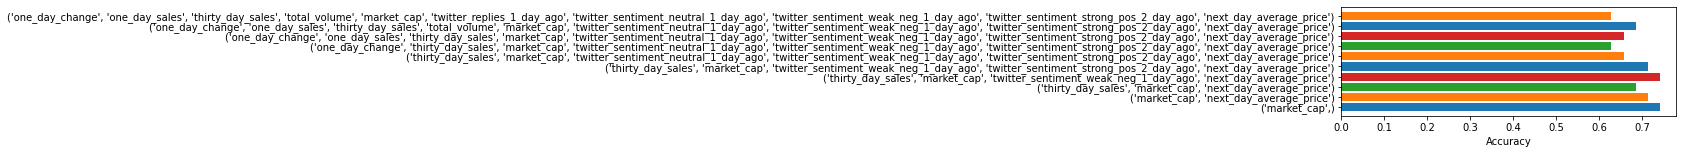

In [ ]:
# Create a horizontal bar chart for visualizing 
# the performance of each subset of features
fig, ax = plt.subplots(figsize=(6,2))
y_pos = np.arange(len(sfs_results))
ax.barh(y_pos, 
        sfs_results['avg_score'], 
        color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax.set_yticks(y_pos)
ax.set_yticklabels(sfs_results['feature_names'])
ax.set_xlabel('Accuracy')
plt.show()

###ANOVA F-value

In [ ]:
from sklearn.feature_selection import f_classif
f_value = f_classif(x_train, y_train)

# Print the name and F-value of each feature
for feature in zip(traning_col, f_value[0]):
    print(feature)

('one_day_volume', 2.395477543148181)
('one_day_change', 0.1358635198840291)
('one_day_sales', 4.433031836255235)
('one_day_average_price', 0.6654037173653113)
('seven_day_volume', 0.7759078710713884)
('seven_day_change', 0.4438550129649823)
('seven_day_sales', 1.4281395668142314)
('seven_day_average_price', 0.4712100643387006)
('thirty_day_volume', 0.0007814741330715143)
('thirty_day_change', 1.6757552701018474)
('thirty_day_sales', 2.4570851561811478)
('thirty_day_average_price', 0.44491744747794976)
('total_volume', 0.009283728812406614)
('total_sales', 0.3376331089941154)
('total_supply', 1.5147263594363696)
('count', 1.5147263594363696)
('num_owners', 1.5383817010054908)
('average_price', 0.08246993492023823)
('num_reports', 1.910655716582092)
('market_cap', 0.012190852459875992)
('floor_price', 0.5614552500142361)
('twitter_tweets_1_day_ago', 0.020245000562677595)
('twitter_retweets_1_day_ago', 1.0837273942410028)
('twitter_replies_1_day_ago', 0.09999603567530169)
('twitter_likes

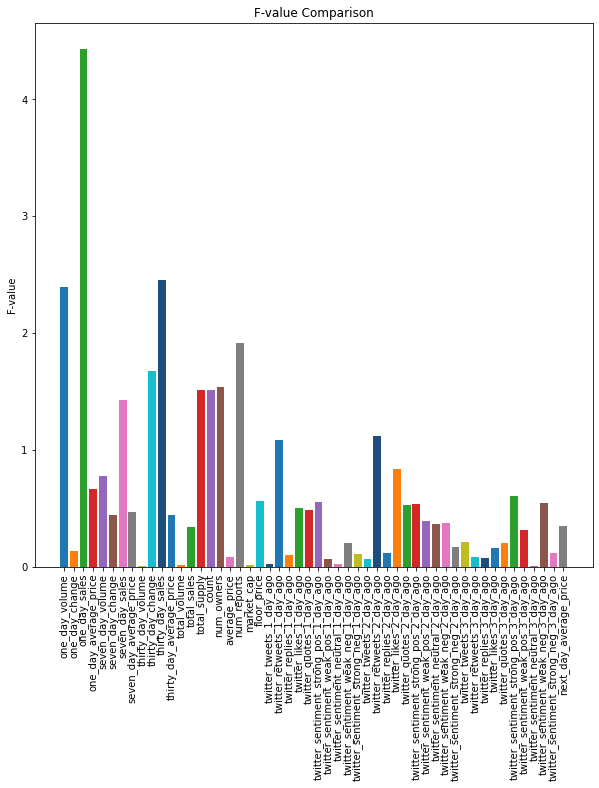

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(x=traning_col, height=f_value[0], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1e4e7e'])
plt.xticks(rotation='vertical')
plt.ylabel('F-value')
plt.title('F-value Comparison')
plt.show()

###Mutual Information

In [ ]:
from sklearn.feature_selection import mutual_info_classif
MI_score = mutual_info_classif(x_train, y_train, random_state=0)

# Print the name and mutual information score of each feature
for feature in zip(traning_col, MI_score):
    print(feature)

('one_day_volume', 0.016998330465528566)
('one_day_change', 0.04535330882050714)
('one_day_sales', 0.04412747116609794)
('one_day_average_price', 0.0)
('seven_day_volume', 0.0)
('seven_day_change', 0.00020663010239974078)
('seven_day_sales', 0.05863922924928455)
('seven_day_average_price', 0.0)
('thirty_day_volume', 0.0028961627919326105)
('thirty_day_change', 0.04562613123618675)
('thirty_day_sales', 0.0)
('thirty_day_average_price', 0.0)
('total_volume', 0.0388567101810513)
('total_sales', 0.03125003114580083)
('total_supply', 0.0)
('count', 0.0)
('num_owners', 0.03800637004499663)
('average_price', 0.0)
('num_reports', 0.0)
('market_cap', 0.07731579078298911)
('floor_price', 0.015377015272784789)
('twitter_tweets_1_day_ago', 0.0)
('twitter_retweets_1_day_ago', 0.0)
('twitter_replies_1_day_ago', 0.0)
('twitter_likes_1_day_ago', 0.025784147822774717)
('twitter_quotes_1_day_ago', 0.0)
('twitter_sentiment_strong_pos_1_day_ago', 0.0)
('twitter_sentiment_weak_pos_1_day_ago', 0.02463870596

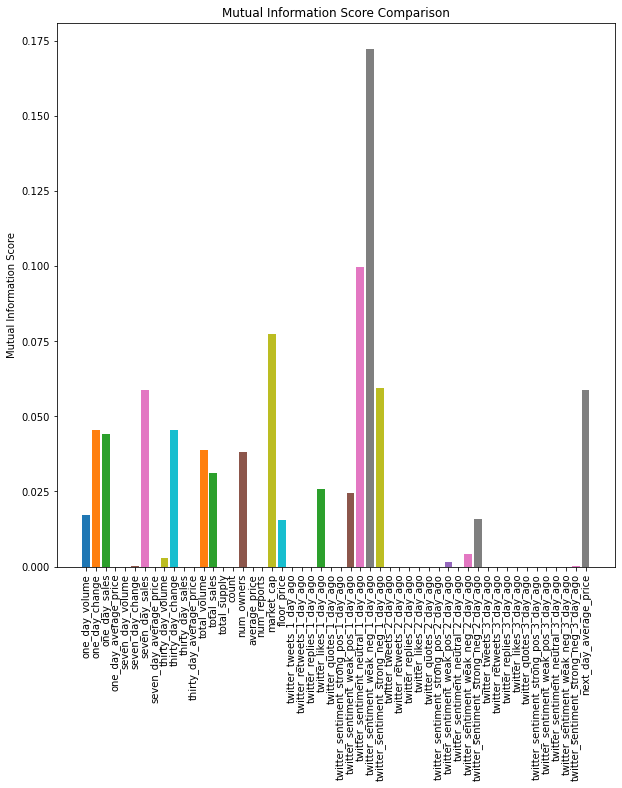

In [ ]:
plt.figure(figsize=(10,10))
plt.bar(x=traning_col, height=MI_score, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1e4e7e'])
plt.xticks(rotation='vertical')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Comparison')

plt.show()

##Apply Models after feature reduction

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [ ]:
print(type(list(sfs_results['feature_names'][8])))

def get_n_largest(N: int, test_list: list, features: list):
  n_best = sorted(range(len(test_list)), key = lambda sub: test_list[sub])[-N:]
  res = list()
  for i in n_best:
    res.append(features[i]) 
  return res

F_value_best = get_n_largest(8, f_value[0], traning_col)
MI_best = get_n_largest(8, MI_score, traning_col)

selected_feature = list(set(F_value_best + MI_best + list(sfs_results['feature_names'][8]) ))
print(len(selected_feature))

<class 'list'>
16


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
def ShowPerformance(predicted_value, actual_value):
    accuracy = accuracy_score(actual_value , predicted_value) * 100
    precision = precision_score(actual_value , predicted_value) * 100
    recall = recall_score(actual_value , predicted_value) * 100
    f1 = f1_score(actual_value , predicted_value, average='weighted')
    print('Accuracy is {:.4f}%\n Precision is {:.4f}%\n Recall is {:.4f}%\nF1 Score is {:.4f}\n'.format(accuracy, precision, recall, f1))

In [ ]:
reduced_x_train = train[selected_feature]
reduced_y_train = train.next_day_price_increased
reduced_x_test = test[selected_feature]
reduced_y_test = test.next_day_price_increased

###Logistic regression

In [ ]:
lr = LogisticRegression()
lr.fit(reduced_x_train,reduced_y_train)
lr_prediction=lr.predict(reduced_x_test)
ShowPerformance(lr_prediction, reduced_y_test)

Accuracy is 77.7778%
 Precision is 100.0000%
 Recall is 33.3333%
F1 Score is 0.7381



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


###SVM

In [ ]:
clf = LinearSVC(penalty='l2', loss='squared_hinge',
                dual=True, tol=0.0001, C=100, multi_class='ovr',
                fit_intercept=True, intercept_scaling=1, class_weight=None,verbose=0
                , random_state=0, max_iter=1000)
clf.fit(reduced_x_train,reduced_y_train)
clf_prediction=clf.predict(reduced_x_test)
ShowPerformance(clf_prediction, reduced_y_test)

Accuracy is 44.4444%
 Precision is 25.0000%
 Recall is 33.3333%
F1 Score is 0.4589



/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


###Decision Tree

In [ ]:
mod_dt = DecisionTreeClassifier(max_depth = 10, random_state = 1)
mod_dt.fit(reduced_x_train,reduced_y_train)
mod_dt_prediction=mod_dt.predict(reduced_x_test)
#print("The accuracy of the Decision Tree is","{:.3f}".format(metrics.accuracy_score(mod_dt_prediction,y_test)))
ShowPerformance(mod_dt_prediction, reduced_y_test)

Accuracy is 55.5556%
 Precision is 33.3333%
 Recall is 33.3333%
F1 Score is 0.5556



###Random Forest

In [ ]:
ensemble_search = RandomForestClassifier()
ensemble_search.fit(reduced_x_train, reduced_y_train)
ensemble_search_prediction=ensemble_search.predict(reduced_x_test)
#print("The accuracy of the Random Forest is","{:.3f}".format(metrics.accuracy_score(ensemble_search_prediction,y_test)))
ShowPerformance(ensemble_search_prediction, reduced_y_test)

Accuracy is 66.6667%
 Precision is 0.0000%
 Recall is 0.0000%
F1 Score is 0.5333



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


###Naive Bayes

In [ ]:
nb_classify= GaussianNB()
nb_classify.fit(reduced_x_train, reduced_y_train)
nb_classify_prediction=nb_classify.predict(reduced_x_test)
ShowPerformance(nb_classify_prediction, reduced_y_test)

Accuracy is 55.5556%
 Precision is 0.0000%
 Recall is 0.0000%
F1 Score is 0.4762

